# Modeling Uncertainty in Random Forests and Neural Networks

This notebook produces scikit-garden and TFP predicitons for LAI for the NAIVE dataset for biome 7 and, using the validation datasets, compares the predicted confidence intervals to:
1. **Epistemic error** (Cross validation error)
2. **Aleatoric error** (The standard deviation given in the algorithm)

## Major Findings

### Datasets
The validation dataset used is independent of the calibration dataset.
### Random Forest
#### Python Version
The Scikit-garden package doesn't seem to be maintained anymore. The highest python version it can run on is 3.7. [Here](https://pypi.org/project/quantile-forest/) is an actively maintained quantile random forest implementation.
#### Quantile Regressor vs Regular Regressor
Scikit-garden provides two random forest regressors to predict confidence intervals. The first is a regressor that provides quantile estimates. This allows us to specify the upper and lower bounds to determine the confidence interval ([*section 1.2*](#1.2-Random-Forest-Quantile-Regression)). The second regressor is a regular random forest regressor that supports standard deviation computations ([*section 1.3*](#1.3-Random-Forest-Regression-with-Standard-Deviation)). Both regressors compute the same mean and similar standard deviations ([*section 1.4*](#1.4-Analysis)), but quantile regressor takes longer to run (approx. 10 mins) in comparison (a few seconds). It would be feasible to use the random forest regressor with standard deviation computations to quantify the confidence interval.

### Neural Network
#### Number of Nodes and Layers
The number of nodes and layers used in all the neural networks were determined by Richard Fernandes using Keras Tuner
#### Multivariate vs Univariate Distributions
We considered using a multivariate distribution when defining the prior and posterior functions but because of the size of our network, we have too many paramaters to train and not enough data. In response, we created a smaller neural network using a multivariate distribution ([*section 2.7*](#2.7-Multivariate-Distribution:-Epistemic-Uncertainty)) to make comparisons to our larger network using a univariate distribution. The results can be found in [*Figure 2.11.4*](#Figure-2.11.4) and [*Figure 2.11.5*](#Figure-2.11.5). The univariate distribution seems reasonable but slightly more optimistic. It should be feasible for our purposes.
#### Prior
In all the networks below, we used a non-trainable prior with zero mean and a standard deviation of 1. We considered using a trainable prior with a `VariableLayer()` but found that the model is unable to make predictions above LAI 5. This cutoff is not as obvious when using a non-trainable prior.

## 0 Inital Setup

In [116]:
# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Import modules for data manipulation. Additional modules for each predictors are imported in their respective sections.
import numpy as np
import pandas as pd
import pickle
import seaborn as sns
from matplotlib import pyplot as plt

The biomes are different [LC_Type3](https://developers.google.com/earth-engine/datasets/catalog/MODIS_061_MCD12Q1) landcover classes.

In [344]:
# List of biome numbers
# This can be used to easily create models and predictions for all biomes by applying a for loop
# For now we will only use one biome (specifically biome 7)
biomes = [1,2,3,4,5,6,7,8]

### 0.1 Dataframe Structure
The datasets used in this notebook is stored in two separate dictionaries. Both dictionary are organized by biome number, with each biome containing a dictionary holding the corresponding dataframe. 

- **calbiomeDictLAI**: this dictionary contains the calibration datasets.
- **valbiomeDictLAI**: this dictionary contains the validation datasets, this is independent from the calibration dataset.

For example, `valbiomeDictLAI[7]['DF']` is used to access the validation dataset of biome 7.

The dictionaries used in this notebook can be found [here](https://drive.google.com/drive/folders/1QnxIRsiAMi8aDEh8qeh_oQ9kLD2tiS3y?usp=share_link). All data has been provided by Richard Fernandes.

In [4]:
# Read in dataset
calbiomeDictLAI = pd.read_pickle('C:/Users/casli/cassidy/data/py37/calbiomeDictLAI.pkl')
valbiomeDictLAI = pd.read_pickle('C:/Users/casli/cassidy/data/py37/valbiomeDictLAI.pkl')

In [348]:
calbiome7DictLAI = calbiomeDictLAI[7]
pd.to_pickle(calbiome7DictLAI, 'C:/Users/casli/cassidy/data/py37/calbiome7DictLAI.pkl')

In [323]:
# List of regressors
regressors = ['red','NIR','cosSZA','cosVZA','cosSA']
# Response
response = 'LAI'
# Scaling of the response value
scaling = 10

# Number of validation samples
valSize = [100, 1000]

# Subsampling calibration and validation data to create training and testing datasets for each biome
for i in biomes:
    dfcal = calbiomeDictLAI[i]['DF']

    calbiomeDictLAI[i]['X_train'] = dfcal[regressors]
    calbiomeDictLAI[i]['y_train'] = dfcal[response]
    
    for size in valSize:
        dfval = valbiomeDictLAI[i]['DF'].sample(size)
        valbiomeDictLAI[i]['X_test_' + str(size)] = dfval[regressors]
        valbiomeDictLAI[i]['y_test_' + str(size)] = dfval[response]

biome = 7
print('Number of calibration samples used:', calbiomeDictLAI[biome]['X_train'].shape[0])

Number of calibration samples used: 376649


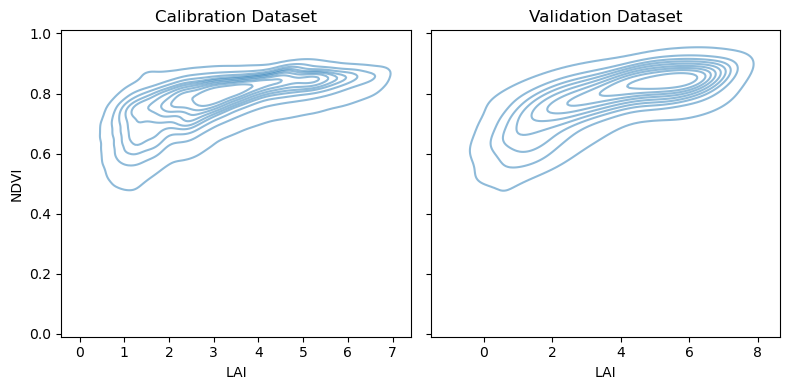

In [327]:
biome = 7
fig, axes = plt.subplots(1, 2, sharey=True, figsize=(8,4))

sns.kdeplot(x=np.divide(calbiomeDictLAI[biome]['y_train'], scaling), y=np.divide(calbiomeDictLAI[biome]['X_train']['NIR'] - calbiomeDictLAI[biome]['X_train']['red'], calbiomeDictLAI[biome]['X_train']['NIR'] + calbiomeDictLAI[biome]['X_train']['red']), s=10, alpha=0.5, lw=0, ax=axes[0])
# axes[0].plot([0, 7], [0, 7], 'k--')

axes[0].set_xlabel("LAI")
axes[0].set_ylabel("NDVI")
axes[0].set_title('Calibration Dataset')

sns.kdeplot(x=np.divide(valbiomeDictLAI[biome]['y_test_1000'], scaling), y=np.divide(valbiomeDictLAI[biome]['X_test_1000']['NIR'] - valbiomeDictLAI[biome]['X_test_1000']['red'], valbiomeDictLAI[biome]['X_test_1000']['NIR'] + valbiomeDictLAI[biome]['X_test_1000']['red']), s=10, alpha=0.5, lw=0, ax=axes[1])
# axes[1].plot([0, 7], [0, 7], 'k--', label='1:1 Line')

axes[1].set_xlabel("LAI")
axes[1].set_title('Validation Dataset')

# plt.xlim([0, 7])
# plt.ylim([0, 7])

fig.tight_layout()

# fig.legend(bbox_to_anchor=(1.12, 0.6), loc='centre left', frameon=0)
plt.show()

_**Figure 0.1.1** NDVI against LAI for the calibration and validation dataset. The validation dataset has been uniformly sampled while the calibration dataset has not._

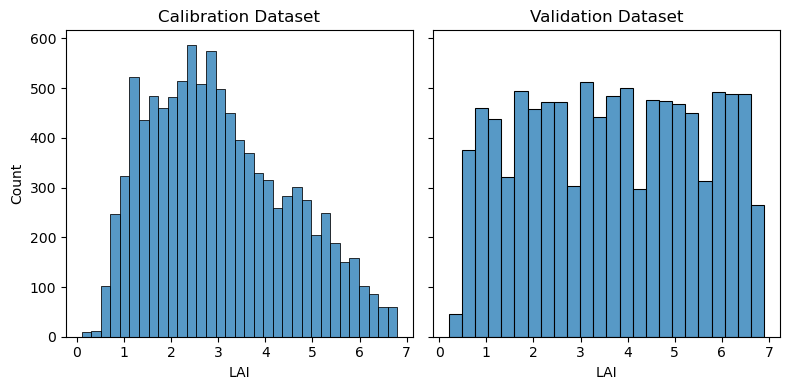

In [390]:
biome = 7
fig, axes = plt.subplots(1, 2, sharey=True, figsize=(8,4))

sns.histplot(x=np.divide(calbiomeDictLAI[biome]['y_train'].sample(10000), scaling), ax=axes[0])
# axes[0].plot([0, 7], [0, 7], 'k--')

axes[0].set_xlabel("LAI")
axes[0].set_title('Calibration Dataset')

sns.histplot(x=np.divide(valbiomeDictLAI[biome]['DF']['LAI'], scaling), ax=axes[1])
# axes[1].plot([0, 7], [0, 7], 'k--', label='1:1 Line')

axes[1].set_xlabel("LAI")
axes[1].set_title('Validation Dataset')

# plt.xlim([0, 7])
# plt.ylim([0, 7])

fig.tight_layout()

# fig.legend(bbox_to_anchor=(1.12, 0.6), loc='centre left', frameon=0)
plt.show()

_**Figure 0.1.2** Number of samples per LAI for the calibration and validation datasets. The validation dataset has been uniformly sampled while the calibration dataset has not._

## 1 Random Forest

In [6]:
import sklearn
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics

In [346]:
def getLeafNodes(rfr):
    nodes = 0
    for tree in rfr.estimators_:
        nodes += tree.get_n_leaves()
    return nodes

In [352]:
def getSplits(rfr):
    splits = 0
    for tree in rfr.estimators_:
        n_nodes = tree.tree_.node_count
        children_left = tree.tree_.children_left
        children_right = tree.tree_.children_right

        stack = [0]  # start with the root node id (0)
        while len(stack) > 0:
            # `pop` ensures each node is only visited once
            node_id = stack.pop()

            # If the left and right child of a node is not the same we have a split
            # node
            is_split_node = children_left[node_id] != children_right[node_id]
            # If a split node, append left and right children and depth to `stack`
            # so we can loop through them
            if is_split_node:
                splits += 1
                stack.append(children_left[node_id])
                stack.append(children_right[node_id])
    return splits

### 1.1 Random Forest Regression

#### 1.1.0 Background Information
A **random forest** is an ensemble model that consists of many **decision trees** and predictions are made by averaging the predictions of each decision tree. In this notebook, we will use *scikit-learn* to implement the random forest regressor. [API Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.htmlhttps://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html)

#### 1.1.1 Defining the Model
First we will need to define our random forest regression model with some basic parameters. We will use 100 trees in our forest. The hyperparameters were determined by Richard Fernandes.

We will use the default function to measure the quality of a split, which is **mean squared error**.

In [328]:
# Creating and fitting a Random Forest Regressor for biome 7 with 100 trees
biome = 7
valbiomeDictLAI[biome]['rf'] = dict()
valbiomeDictLAI[biome]['rf']['model'] = RandomForestRegressor(n_estimators=100,min_samples_leaf=10,max_features=3,bootstrap=True,random_state=0,n_jobs=-1,max_leaf_nodes=10000)

#### 1.1.2 Training the Model
To train our model, we call the `fit` method and pass our training data as parameters.

In [353]:
valbiomeDictLAI[biome]['rf']['model'] = valbiomeDictLAI[biome]['rf']['model'].fit(calbiomeDictLAI[biome]['X_train'], calbiomeDictLAI[biome]['y_train'])

# Total number of leaf nodes and splits
print('Total Leaf Nodes:', getLeafNodes(valbiomeDictLAI[biome]['rf']['model']))
print('Total Splits:', getSplits(valbiomeDictLAI[biome]['rf']['model']))

Total Leaf Nodes: 1000000
Total Splits: 999900


#### 1.1.3 Making Predictions


In [338]:
biome = 7

valSize = [100, 1000]

for size in valSize:
    valbiomeDictLAI[biome]['rf']['y_pred_' + str(size)] = valbiomeDictLAI[biome]['rf']['model'].predict(valbiomeDictLAI[biome]['X_test_' + str(size)])

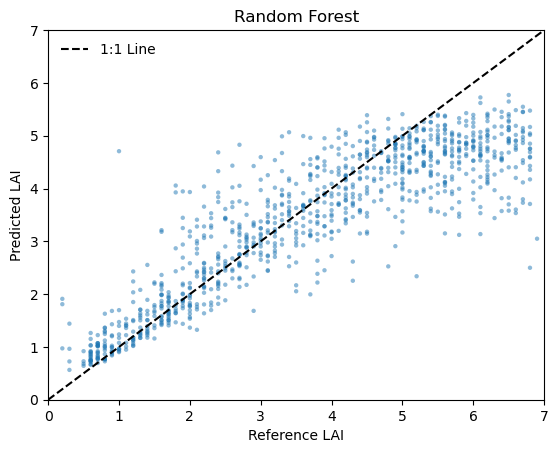

In [339]:
# Plotting the Quantile Regression Forest with error bars
plt.scatter(np.divide(valbiomeDictLAI[biome]['y_test_1000'], scaling), np.divide(valbiomeDictLAI[biome]['rf']['y_pred_1000'], scaling), s=10, alpha=0.5, edgecolors='none')
plt.plot([0, 7], [0, 7], 'k--', label='1:1 Line')

plt.xlabel("Reference LAI")
plt.ylabel("Predicted LAI")
plt.title('Random Forest')

plt.xlim([0, 7])
plt.ylim([0, 7])
plt.legend(frameon=0)
plt.show()

_**Figure 1.1.1** Predicted LAI from a random forest regressor in comparison to the reference LAI for 1000 samples. A one-to-one is plotted to show relatively how well the predictions are._

### 1.2 Random Forest Quantile Regression

To use Scikit-Garden:

| Package       | Version          | Notes                    |
|:--------------|:-----------------|:-------------------------|
| python        | 3.7              |                          |
| numpy         | 1.21  (default)  |                          |
| matplotlib    | 3.5   (default)  |                          |
| pandas        | 1.2   (default)  |                          |
| scikit-learn  | 0.22  (default)  |                          |
| scikit-garden | 0.1.3 (default)  | install with conda-forge |
| jupyterlab    | 3.6   (default)  | install with pip         |

In [14]:
# Import scikit-garden module
from skgarden import RandomForestQuantileRegressor

#### 1.2.0 Background Information
A random forest regressor that provides quantile estimates.
[API Documentation](https://scikit-garden.github.io/api/#skgardenquantilerandomforestquantileregressor)

#### 1.2.1 Defining the Model
We can define the random forest regressor model with the same parameters as our random forest regressor above. Again we will use 100 trees.

In [356]:
# Creating a Random Forest Quantile Regressor (100 trees per forest)
biome = 7
valbiomeDictLAI[biome]['rfqr'] = dict()
valbiomeDictLAI[biome]['rfqr']['model'] = RandomForestQuantileRegressor(n_estimators=100,min_samples_leaf=10,max_features=3,bootstrap=True,random_state=0,verbose=0,n_jobs=-1,max_leaf_nodes=10000)

#### 1.2.2 Training our Model
Again, to train our model, we call the `fit` method and pass our training data as parameters.

In [357]:
# Fitting a Random Forest Quantile Regressor for each biome type
valbiomeDictLAI[biome]['rfqr']['model'] = valbiomeDictLAI[biome]['rfqr']['model'].fit(calbiomeDictLAI[biome]['X_train'], calbiomeDictLAI[biome]['y_train'])

# Total number of leaf nodes and splits
print('Total Leaf Nodes:', getLeafNodes(valbiomeDictLAI[biome]['rfqr']['model']))
print('Total Splits:', getSplits(valbiomeDictLAI[biome]['rfqr']['model']))

Total Leaf Nodes: 1000000
Total Splits: 999900


#### 1.2.3 Making Predictions
Similar to the random forest regressor, we can make prediction with our model using the `.predict()` method. The difference is that we will specify the quantiles at which we want our predictions. In this case, we will specify the upper quantile at 84 and the lower quantile at 16, giving us a 68% prediction interval. If the quantile is not set, the model will return the expected value.

In [360]:
name = 'rfqr'
biome = 7

valSize = [100, 1000]

for size in valSize:
    valbiomeDictLAI[biome][name]['mean_' + str(size)] = valbiomeDictLAI[biome][name]['model'].predict(valbiomeDictLAI[biome]['X_test_' + str(size)])

    valbiomeDictLAI[biome][name]['lower_' + str(size)] = valbiomeDictLAI[biome][name]['model'].predict(valbiomeDictLAI[biome]['X_test_' + str(size)], quantile=16)
    valbiomeDictLAI[biome][name]['upper_' + str(size)] = valbiomeDictLAI[biome][name]['model'].predict(valbiomeDictLAI[biome]['X_test_' + str(size)], quantile=84)
    valbiomeDictLAI[biome][name]['stddev_' + str(size)] = (valbiomeDictLAI[biome][name]['upper_' + str(size)] - valbiomeDictLAI[biome][name]['lower_' + str(size)]) / 2

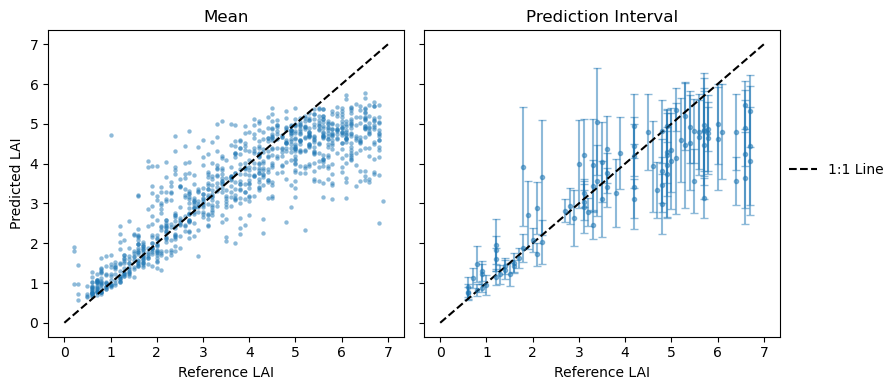

In [361]:
name = 'rfqr'
biome = 7

fig, axes = plt.subplots(1, 2, sharey=True, figsize=(8,4))

axes[0].scatter(np.divide(valbiomeDictLAI[biome]['y_test_1000'], scaling), np.divide(valbiomeDictLAI[biome][name]['mean_1000'], scaling), s=10, alpha=0.5, lw=0)
axes[0].plot([0, 7], [0, 7], 'k--')

axes[0].set_xlabel("Reference LAI")
axes[0].set_ylabel("Predicted LAI")
axes[0].set_title('Mean')

axes[1].errorbar(np.divide(valbiomeDictLAI[biome]['y_test_100'], scaling), np.divide(valbiomeDictLAI[biome][name]['mean_100'], scaling), np.divide(valbiomeDictLAI[biome][name]['stddev_100'], scaling), fmt='o', ms=3, alpha=0.5, capsize=3)
axes[1].plot([0, 7], [0, 7], 'k--', label='1:1 Line')

axes[1].set_xlabel("Reference LAI")
axes[1].set_title('Prediction Interval')

# plt.xlim([0, 7])
# plt.ylim([0, 7])

fig.tight_layout()

fig.legend(bbox_to_anchor=(1.12, 0.6), loc='centre left', frameon=0)
plt.show()

_**Figure 1.2.1** Predicted LAI with from a random forest quantile regressor in comparison to the reference LAI. Left plot shows a comparison of the mean predictions with respect to 1000 validation samples. Right plot shows mean predictions with error bars indicating the 68% confidence interval of each prediction with respect to 100 validation samples. A one-to-one is plotted to show relatively how well the predictions are._

### 1.3 Random Forest Regression with Standard Deviation

In [18]:
from skgarden import RandomForestRegressor as rfrgarden

#### 1.2.0 Background Information
A random forest regressor that supports conditional standard deviation computation. [API Documentation](https://scikit-garden.github.io/api/#skgardenforestrandomforestregressor)

#### 1.3.1 Defining the Model

In [354]:
biome = 7
valbiomeDictLAI[biome]['rfstddev'] = dict()
valbiomeDictLAI[biome]['rfstddev']['model'] = rfrgarden(n_estimators=100,min_samples_leaf=10,max_features=3,bootstrap=True,random_state=0,verbose=0,n_jobs=-1,max_leaf_nodes=10000)

#### 1.3.2 Training the Model
To train our model, we call the `fit` method and pass our training data as parameters.

In [355]:
# Fitting a Random Forest Quantile Regressor for each biome type
valbiomeDictLAI[biome]['rfstddev']['model'] = valbiomeDictLAI[biome]['rfstddev']['model'].fit(calbiomeDictLAI[biome]['X_train'], calbiomeDictLAI[biome]['y_train'])

# Total number of leaf nodes and splits
print('Total Leaf Nodes:', getLeafNodes(valbiomeDictLAI[biome]['rfstddev']['model']))
print('Total Splits:', getSplits(valbiomeDictLAI[biome]['rfstddev']['model']))

Total Leaf Nodes: 1000000
Total Splits: 999900


#### 1.3.3 Making Predictions

In [362]:
name = 'rfstddev'
biome = 7

valSize = [100, 1000]

for size in valSize:

    valbiomeDictLAI[biome][name]['mean_' + str(size)], valbiomeDictLAI[biome][name]['stddev_' + str(size)] = valbiomeDictLAI[biome][name]['model'].predict(valbiomeDictLAI[biome]['X_test_' + str(size)], return_std=True)

    valbiomeDictLAI[biome][name]['lower_' + str(size)] = valbiomeDictLAI[biome][name]['mean_' + str(size)] - valbiomeDictLAI[biome][name]['stddev_' + str(size)]
    valbiomeDictLAI[biome][name]['upper_' + str(size)] = valbiomeDictLAI[biome][name]['mean_' + str(size)] + valbiomeDictLAI[biome][name]['stddev_' + str(size)]

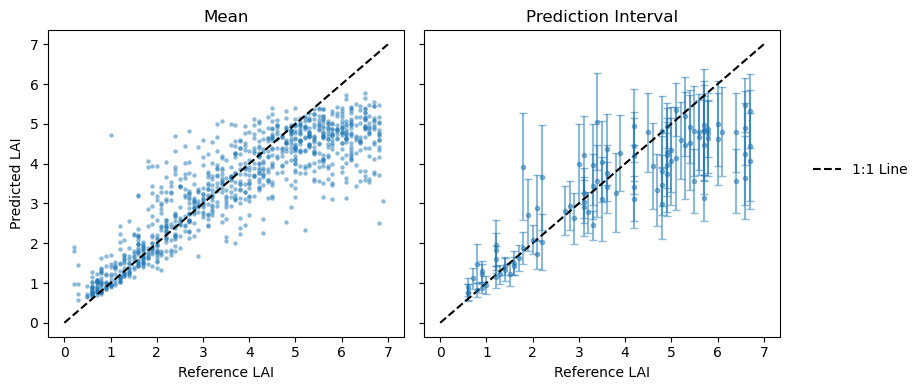

In [363]:
name = 'rfstddev'
biome = 7

fig, axes = plt.subplots(1, 2, sharey=True, figsize=(8,4))

axes[0].scatter(np.divide(valbiomeDictLAI[biome]['y_test_1000'], scaling), np.divide(valbiomeDictLAI[biome][name]['mean_1000'], scaling), s=10, alpha=0.5, lw=0)
axes[0].plot([0, 7], [0, 7], 'k--', label='1:1 Line')

axes[0].set_xlabel("Reference LAI")
axes[0].set_ylabel("Predicted LAI")
axes[0].set_title('Mean')

axes[1].errorbar(np.divide(valbiomeDictLAI[biome]['y_test_100'], scaling), np.divide(valbiomeDictLAI[biome][name]['mean_100'], scaling), np.divide(valbiomeDictLAI[biome][name]['stddev_100'], scaling), fmt='o', ms=3, alpha=0.5, capsize=3)
axes[1].plot([0, 7], [0, 7], 'k--')

axes[1].set_xlabel("Reference LAI")
axes[1].set_title('Prediction Interval')

# plt.xlim([0, 7])
# plt.ylim([0, 7])

fig.tight_layout()

fig.legend(bbox_to_anchor=(1.15, 0.6), loc='centre', frameon=0)
plt.show()

_**Figure 1.3.1** Predicted LAI with from a random forest quantile regressor in comparison to the reference LAI. Left plot shows a comparison of the mean predictions with respect to 1000 validation samples. Right plot shows mean predictions with error bars indicating the 68% confidence interval of each prediction with respect to 100 validation samples. A one-to-one is plotted to show relatively how well the predictions are._

### 1.4 Analysis

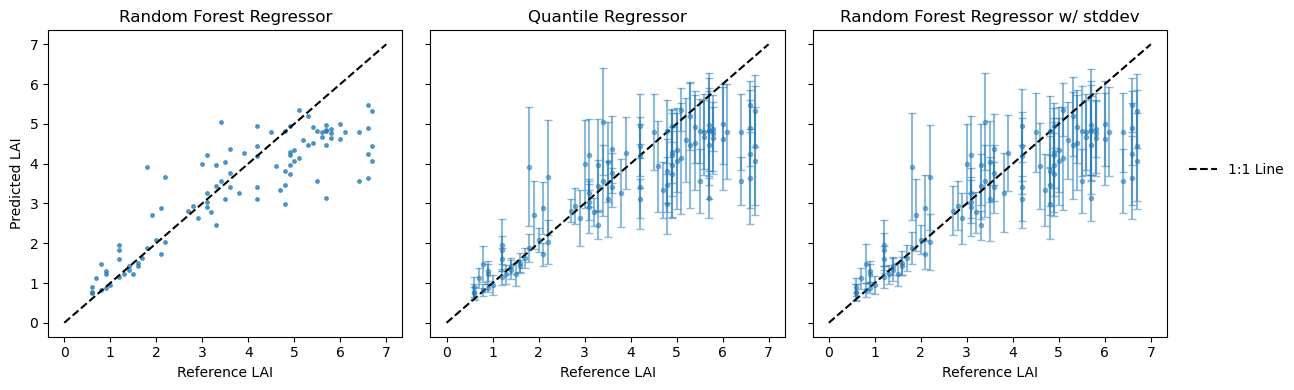

In [364]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4), sharey=True)

axes[0].scatter(np.divide(valbiomeDictLAI[biome]['y_test_100'], scaling), np.divide(valbiomeDictLAI[biome]['rf']['y_pred_100'], scaling), s=12, alpha=0.8, lw=0)
axes[0].plot([0, 7], [0, 7], 'k--')
axes[0].set_xlabel("Reference LAI")
axes[0].set_ylabel("Predicted LAI")
axes[0].set_title('Random Forest Regressor')

axes[1].errorbar(np.divide(valbiomeDictLAI[biome]['y_test_100'], scaling), np.divide(valbiomeDictLAI[biome]['rfqr']['mean_100'], scaling), np.divide(valbiomeDictLAI[biome]['rfqr']['stddev_100'], scaling), fmt='o', ms=3, alpha=0.5, capsize=3)
axes[1].plot([0, 7], [0, 7], 'k--')
axes[1].set_xlabel("Reference LAI")
axes[1].set_title('Quantile Regressor')

axes[2].errorbar(np.divide(valbiomeDictLAI[biome]['y_test_100'], scaling), np.divide(valbiomeDictLAI[biome]['rfstddev']['mean_100'], scaling), np.divide(valbiomeDictLAI[biome]['rfstddev']['stddev_100'], scaling), fmt='o', ms=3, alpha=0.5, capsize=3)
axes[2].plot([0, 7], [0, 7], 'k--', label='1:1 Line')
axes[2].set_xlabel("Reference LAI")
axes[2].set_title('Random Forest Regressor w/ stddev')

fig.legend(bbox_to_anchor=(1.08, 0.6), loc='centre', frameon=0)
plt.tight_layout()
plt.show()

_**Figure 1.4.1** Predicted LAI from all three random forest regressors in comparison to the reference LAI. Left plot shows a comparison of the predicted values using a scikit-learn random forest regressor with respect to 100 validation samples. Other two plots show mean predictions with error bars indicating the 68% confidence interval of each prediction with respect to 100 validation samples. A one-to-one is plotted to show relatively how well the predictions are. It can be observed that the mean predictions for all 3 scatter plots are very similar, and the confidence interval of the right two graphs are very similar._

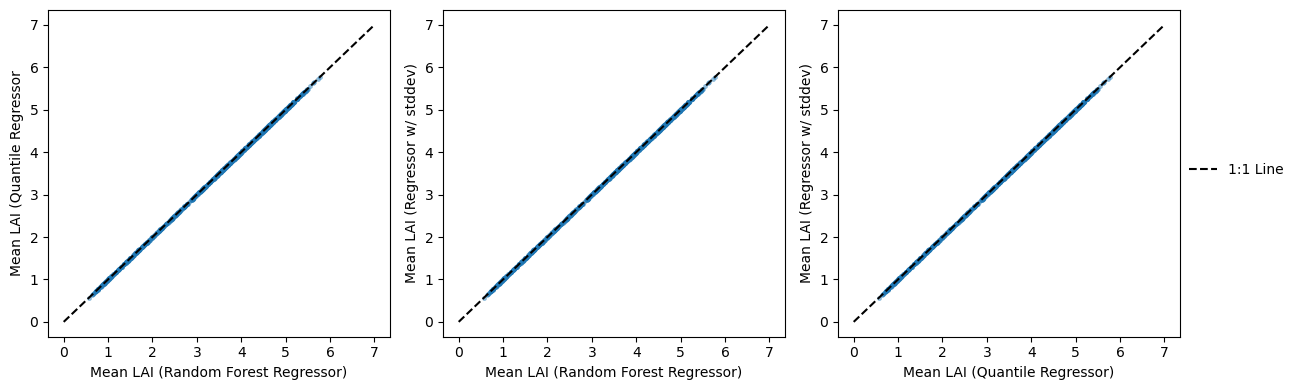

In [365]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4), sharey=False)

axes[0].scatter(np.divide(valbiomeDictLAI[biome]['rf']['y_pred_1000'], scaling), np.divide(valbiomeDictLAI[biome]['rfqr']['mean_1000'], scaling), alpha=0.5, s=12, lw=0)
axes[0].plot([0, 7], [0, 7], 'k--')
axes[0].set_xlabel("Mean LAI (Random Forest Regressor)")
axes[0].set_ylabel("Mean LAI (Quantile Regressor")

axes[1].scatter(np.divide(valbiomeDictLAI[biome]['rf']['y_pred_1000'], scaling), np.divide(valbiomeDictLAI[biome]['rfstddev']['mean_1000'], scaling), alpha=0.5, s=12, lw=0)
axes[1].plot([0, 7], [0, 7], 'k--')
axes[1].set_xlabel("Mean LAI (Random Forest Regressor)")
axes[1].set_ylabel("Mean LAI (Regressor w/ stddev)")

axes[2].scatter(np.divide(valbiomeDictLAI[biome]['rfqr']['mean_1000'], scaling), np.divide(valbiomeDictLAI[biome]['rfstddev']['mean_1000'], scaling), alpha=0.5, s=12, lw=0)
axes[2].plot([0, 7], [0, 7], 'k--', label='1:1 Line')
axes[2].set_xlabel("Mean LAI (Quantile Regressor)")
axes[2].set_ylabel("Mean LAI (Regressor w/ stddev)")

fig.legend(bbox_to_anchor=(1.08, 0.6), loc='centre', frameon=0)
plt.tight_layout()
plt.show()

_**Figure 1.4.2** Comparing the mean predictions of all three regressors with respect to each other._

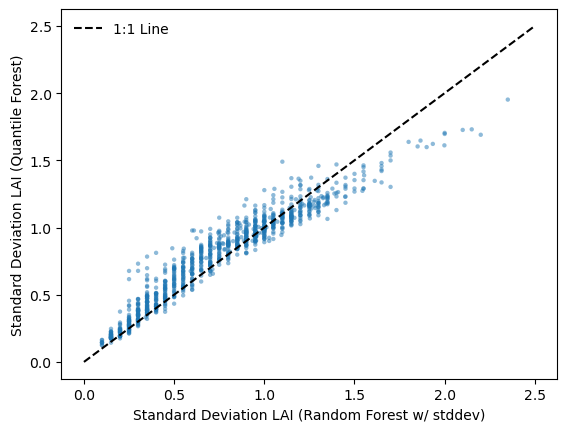

In [366]:
plt.scatter(np.divide(valbiomeDictLAI[biome]['rfqr']['stddev_1000'], scaling), np.divide(valbiomeDictLAI[biome]['rfstddev']['stddev_1000'], scaling), s=10, alpha=0.5, edgecolors='none')
    
plt.plot([0, 2.5], [0, 2.5], 'k--', label='1:1 Line')
plt.xlabel("Standard Deviation LAI (Random Forest w/ stddev)")
plt.ylabel("Standard Deviation LAI (Quantile Forest)")
plt.legend(frameon=0)
plt.show()

_**Figure 1.4.3** Comparing the standard deviation from the quantile regressor and the regressor with standard deviation. Both regressors are predicting very similar but not identical values._

## 2 Neural Network

In [33]:
# Import Modules
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import tensorflow_probability as tfp
tfd = tfp.distributions
tfpl = tfp.layers

### 2.0 Introduction

#### 2.0.1 Sources
[Probabilistic regression](https://www.tensorflow.org/probability/examples/Probabilistic_Layers_Regression) by Tensorflow.org

#### 2.0.2 Dataframe Structure
`valbiomeDictLAI[biome#]` is a dictionary that will hold another dictionary with naming convention `[type of neural network]_[#neurons]_..._[output shape]_[Type of Error/None]`.

**Examples:** \
`nn_80_25_1` is a regular neural network with 2 hidden layers, 80 neurons in the first and 25 in the second, with output shape 1.\
`pnn_8_1` is a probabilistic neural network with 1 hidden layer with 8 neurons and output shape 1 that measure aleatoric and epistemic error.\
`pnn_8_2_1_A` is a probabilistic neural network with 2 hidden layer with 8 neurons in the first and 2 in the second and output shape 1. This network measures aleatoric error only.

Each of these dictionaries will hold information about the model, the history, the number of parameters, etc.

### 2.1 Regular Neural Network

#### 2.1.1 Normalizing the Input Data
Before defining the model, we first normalize the inputs using the Keras `Normalization()` layer to transform the data to be on a similar scale. We call the `adapt()` method on our input data to get the mean and standard deviation of the dataset and set our normalization layer to use those parameters.

In [34]:
normalizer = layers.Normalization(input_shape=[5,], axis=None)
normalizer.adapt(np.array(calbiomeDictLAI[biome]['X_train']))

#### 2.1.2 Defining the Model
To build our model, we will use `keras.Sequnential()`, which groups a linear stack of layers into a `keras.Model()`. It also provides training and inference features on this model.

The first layer in our model is the normalizer we defined above. The subsequent layers are all `Dense()` (interconnected) layers. The parameter `units` sets the number of neurons in each layer. In our case, we create a 2 hidden layer network with 80 neurons in the first and 25 in the second. This was determined by Richard Fernandes using **Keras Tuner**. The `activation` parameter specifies an activation function. This is the function that decides whether a particular neuron in the layer should be taken into account. We use a **relu** activation function to add non-linearity to the network.

Now that we've defined our model, we need to compile it by specifying a loss function and an optimizer. For consistency, we will use the **mean squared error** as our loss function as this is the loss function used in *scikit-learn*'s Random Forest. The optimizer we will use is **Adam**, with a learning rate of of **0.01**. We can also include any desired metrics using the `metrics` parameter. For now, we will only include the **root mean squared error**.


Finally we will print out a summary table of our model to see the number of parameters in each layer.

In [35]:
# Name of the Network
name = 'nn_80_25_1'
# Biome number 
biome = 7

# Create a new dictionary to save the Network
valbiomeDictLAI[biome][name] = dict()

valbiomeDictLAI[biome][name]['model'] = tf.keras.Sequential([
    # Normalizing data
    normalizer,
    layers.Dense(units=80, activation='relu'),
    layers.Dense(units=25, activation='relu'),
    layers.Dense(units=1)
])

# Compile the model with the specified loss and optimizer functions
valbiomeDictLAI[biome][name]['model'].compile(loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), metrics=[tf.keras.metrics.RootMeanSquaredError()])
valbiomeDictLAI[biome][name]['model'].summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 5)                3         
 n)                                                              
                                                                 
 dense (Dense)               (None, 80)                480       
                                                                 
 dense_1 (Dense)             (None, 25)                2025      
                                                                 
 dense_2 (Dense)             (None, 1)                 26        
                                                                 
Total params: 2,534
Trainable params: 2,531
Non-trainable params: 3
_________________________________________________________________


#### 2.1.3 Training the Model
We will train the model for 50 epochs and plot the loss to confirm that the algorithm has converged.

Epoch 1/50
11771/11771 [==============================] - 28s 2ms/step - loss: 90.2323 - root_mean_squared_error: 9.4991
Epoch 2/50
11771/11771 [==============================] - 27s 2ms/step - loss: 78.0444 - root_mean_squared_error: 8.8343
Epoch 3/50
11771/11771 [==============================] - 34s 3ms/step - loss: 76.4575 - root_mean_squared_error: 8.7440
Epoch 4/50
11771/11771 [==============================] - 41s 3ms/step - loss: 75.6238 - root_mean_squared_error: 8.6962
Epoch 5/50
11771/11771 [==============================] - 49s 4ms/step - loss: 74.8340 - root_mean_squared_error: 8.6507
Epoch 6/50
11771/11771 [==============================] - 45s 4ms/step - loss: 74.4609 - root_mean_squared_error: 8.6291
Epoch 7/50
11771/11771 [==============================] - 48s 4ms/step - loss: 74.0076 - root_mean_squared_error: 8.6028
Epoch 8/50
11771/11771 [==============================] - 61s 5ms/step - loss: 73.9664 - root_mean_squared_error: 8.6004
Epoch 9/50
11771/11771 [========

Text(0, 0.5, 'Loss')

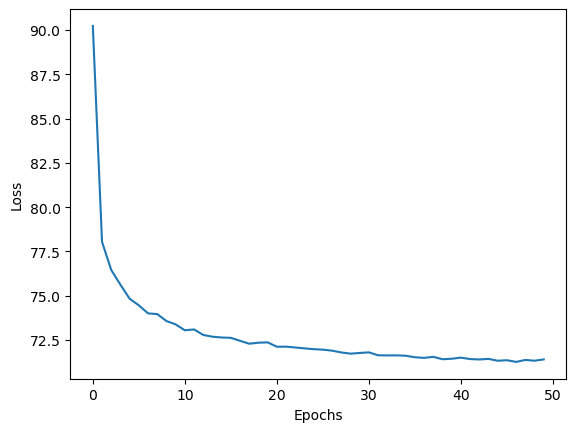

In [36]:
# Set verbose=0 to hide loss information
valbiomeDictLAI[biome][name]['history'] = valbiomeDictLAI[biome][name]['model'].fit(calbiomeDictLAI[biome]['X_train'].to_numpy(), calbiomeDictLAI[biome]['y_train'].to_numpy(), epochs=50, verbose=1)

# Plotting loss
plt.plot(valbiomeDictLAI[biome][name]['history'].history['loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')

_**Figure 2.1.1** Loss convergence trained over 50 epochs for a regular 80-25-1 neural network. Loss converges indicating the model has been correctly trained._

#### 2.1.4 Making Predictions
Now that our model has been trained, we can start making predictions using our validation dataset. To visual our predictions, we can scatterplot the predicted results against the reference values.

In [37]:
name = 'nn_80_25_1'
biome = 7

# Sample size of our validation datasets
valSize = [100, 1000]

# We will make predictions for both 100 and 1000 validation samples for visualization and analysis purposes later in the notebook
for size in valSize: 
    valbiomeDictLAI[biome][name]['y_pred_' + str(size)] = valbiomeDictLAI[biome][name]['model'].predict(valbiomeDictLAI[biome]['X_test_' + str(size)]).flatten()

32/32 [==============================] - 0s 3ms/step


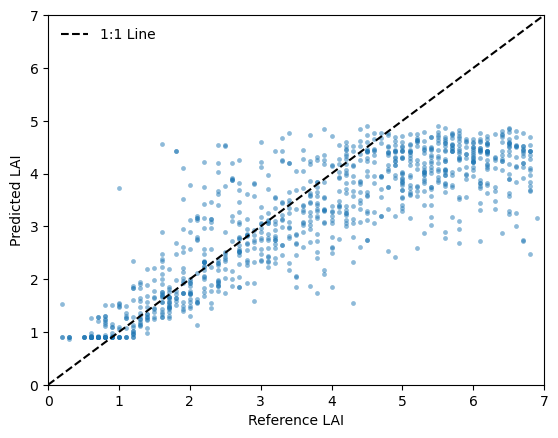

In [367]:
name = 'nn_80_25_1'
biome = 7

plt.scatter(np.divide(valbiomeDictLAI[biome]['y_test_1000'], scaling), np.divide(valbiomeDictLAI[biome][name]['y_pred_1000'], scaling), alpha=0.5, s=12, lw=0)
plt.plot([0, 7], [0, 7], 'k--', label='1:1 Line')

plt.xlabel("Reference LAI")
plt.ylabel("Predicted LAI")

plt.xlim([0, 7])
plt.ylim([0, 7])
plt.legend(frameon=0)
plt.show()

_**Figure 2.1.2** Predicted LAI from a regular 80-25-1 neural network in comparison to the reference LAI for 1000 validation samples. A one-to-one is plotted to show relatively how well the predictions are. It can be observed that for LAI values greater than 4.5, the model tends to underpredict. This behaviour is expected._

### 2.2 Aleatoric Uncertainty

#### 2.2.0 Background Information
**Aleatoric Uncertainity**, or data uncertainty, relates to the data generating process that produces our data and captures the unpredictable randomness in outcomes when repeating the same experiement with exactly the same settings many times. The most important fact about aleatoric uncertainty is that it cannot be reduced by adding more data.

#### 2.2.1 Defining a log-likelihood Loss Function
We first create a function that takes some data and distribution object and computes log-liklihood of the data given to the distribution. Like any TensorFlow-compatible loss function, the function takes true values `y_true` and predictions `y_pred`. Then we compute the log of the PDF with the `log_prob()` method and reverse the sign to maximize the liklihood. 

In [39]:
negloglik = lambda y_true, y_pred: -y_pred.log_prob(y_true)

#### 2.2.2 Defining the Model
The first layer of our model is the same normalizer we've defined before to normalize our input data.

The next three layers are regular Keras `Dense` layers. The third `Dense()` layer's purpose is to parametrize the distribution in the last layer. There are 2 output nodes —— mean and standard deviation.

The last layer is a `DistributionLambda()` layer, a special Keras layer that uses a Python lambda to construct a distribution conditioned on the layer input. In this case, we are using a `normal()` distribution.

`softplus` is a smooth approximation of relu. Like relu, softplus always takes on positive values.softplus is a smooth approximation of relu. Like relu, softplus always takes on positive values.

In [40]:
# Name of the Network
name = 'pnn_80_25_1_A'
# Biome number 
biome = 7

# Create a new dictionary to save the Network
valbiomeDictLAI[biome][name] = dict()

valbiomeDictLAI[biome][name]['model'] = tf.keras.Sequential([
    normalizer,
    layers.Dense(80, activation='relu'),
    layers.Dense(25, activation='relu'),
    layers.Dense(2), # 2 outputs — mean and stddev
    tfp.layers.DistributionLambda(
        # uncertain about the meaning of the arguments
        lambda t: tfd.Normal(loc=t[..., :1],
                             scale=1e-3 + tf.math.softplus(0.05 * t[...,1:]))),
])

valbiomeDictLAI[biome][name]['model'].compile(optimizer=tf.optimizers.Adam(learning_rate=0.01), loss=negloglik, metrics=[tf.keras.metrics.RootMeanSquaredError()])
valbiomeDictLAI[biome][name]['model'].summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 5)                3         
 n)                                                              
                                                                 
 dense_3 (Dense)             (None, 80)                480       
                                                                 
 dense_4 (Dense)             (None, 25)                2025      
                                                                 
 dense_5 (Dense)             (None, 2)                 52        
                                                                 
 distribution_lambda (Distri  ((None, 1),              0         
 butionLambda)                (None, 1))                         
                                                                 
Total params: 2,560
Trainable params: 2,557
Non-traina

#### 2.2.3 Training the Model
We will train the model for 50 epochs and plot the loss function to confirm that the algorithm has converged.

Epoch 1/50
Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
11771/11771 [==============================] - 55s 4ms/step - loss: 4.6734 - root_mean_squared_error: 14.5455
Epoch 2/50
11771/11771 [==============================] - 55s 5ms/step - loss: 3.4730 - root_mean_squared_error: 12.8723
Epoch 3/50
11771/11771 [==============================] - 51s 4ms/step - loss: 3.4241 - root_mean_squared_error: 12.3704
Epoch 4/50
11771/11771 [==============================] - 48s 4ms/step - loss: 3.4122 - root_mean_squared_error: 12.2826
Epoch 5/50
11771/11771 [==============================] - 47s 4ms/step - loss: 3.4036 - root_mean_squared_error: 12.2644
Epoch 6/50
11771/11771 [==============================] - 48s 4ms/step - loss: 3.3980 - root_mean_squared_error: 12.1966
Epoch 7/50
11771/11771 [==============================] - 48s 4ms/step - 

Text(0, 0.5, 'Loss')

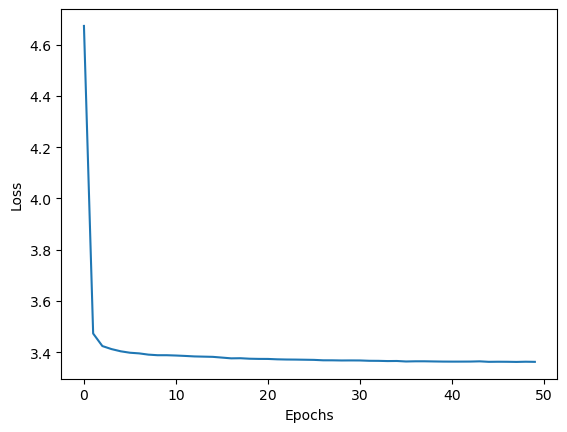

In [41]:
# Train the model for 50 epochs
name = 'pnn_80_25_1_A'
biome = 7

valbiomeDictLAI[biome][name]['history'] = valbiomeDictLAI[biome][name]['model'].fit(calbiomeDictLAI[biome]['X_train'].to_numpy(), calbiomeDictLAI[biome]['y_train'].to_numpy(), epochs=50, verbose=1)

plt.plot(valbiomeDictLAI[biome][name]['history'].history['loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')

_**Figure 2.2.1** Loss convergence trained over 50 epochs for a probabilistic 80-25-1 neural network predicting aleatoric uncertainty. Loss converges, indicating the model has been correctly trained._

#### 2.2.4 Making Predictions
Now that our model has been trained, we can start making predictions using our validation dataset. Since this is a probabilistic neural network, we can predict the mean and standard deviation.

In [42]:
name = 'pnn_80_25_1_A'
biome = 7

valSize = [100, 1000]

for size in valSize:
    # Model returns a distribution object
    valbiomeDictLAI[biome][name]['y_model_' + str(size)] = valbiomeDictLAI[biome][name]['model'](valbiomeDictLAI[biome]['X_test_' + str(size)])

    # Mean and standard deviation
    valbiomeDictLAI[biome][name]['mean_' + str(size)] = valbiomeDictLAI[biome][name]['y_model_' + str(size)].mean().numpy().flatten()
    valbiomeDictLAI[biome][name]['stddev_' + str(size)] = valbiomeDictLAI[biome][name]['y_model_' + str(size)].stddev().numpy().flatten()

    # Upper and lower bound of confidence interval
    # 1 stddev from the mean gives approx. the 68% confidence interval
    valbiomeDictLAI[biome][name]['lower_' + str(size)] = valbiomeDictLAI[biome][name]['mean_' + str(size)] - valbiomeDictLAI[biome][name]['stddev_' + str(size)]
    valbiomeDictLAI[biome][name]['upper_' + str(size)] = valbiomeDictLAI[biome][name]['mean_' + str(size)] + valbiomeDictLAI[biome][name]['stddev_' + str(size)]

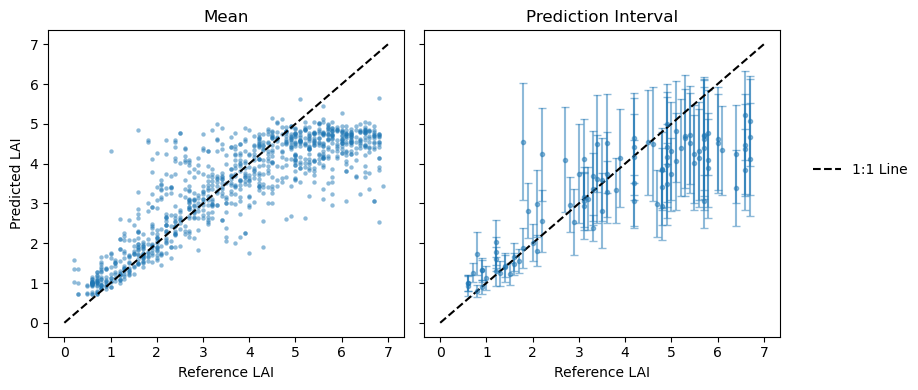

In [213]:
name = 'pnn_80_25_1_A'
biome = 7

fig, axes = plt.subplots(1, 2, sharey=True, figsize=(8,4))

# Plot the mean of the predictions
axes[0].scatter(np.divide(valbiomeDictLAI[biome]['y_test_1000'], scaling), np.divide(valbiomeDictLAI[biome][name]['mean_1000'], scaling), s=10, alpha=0.5, lw=0)
axes[0].plot([0, 7], [0, 7], 'k--', label='1:1 Line')

axes[0].set_xlabel("Reference LAI")
axes[0].set_ylabel("Predicted LAI")
axes[0].set_title('Mean')

# Plot the confidence interval
axes[1].errorbar(np.divide(valbiomeDictLAI[biome]['y_test_100'], scaling), np.divide(valbiomeDictLAI[biome][name]['mean_100'], scaling), np.divide(valbiomeDictLAI[biome][name]['stddev_100'], scaling), fmt='o', ms=3, alpha=0.5, capsize=3)
axes[1].plot([0, 7], [0, 7], 'k--')

axes[1].set_xlabel("Reference LAI")
axes[1].set_title('Prediction Interval')

# plt.xlim([0, 7])
# plt.ylim([0, 7])

fig.tight_layout()

fig.legend(bbox_to_anchor=(1.12, 0.6), loc='centre left', frameon=0)
plt.show()

_**Figure 2.2.2** Predicted LAI with aleatoric uncertainity from a probabilistic 80-25-1 neural network in comparison to the reference LAI. Left plot shows a comparison of the means with respect to 1000 validation samples. Right plot shows mean predictions with error bars indicating the 68% confidence interval of each prediction with respect to 100 validation samples. A one-to-one is plotted to show relatively how well the predictions are. It can be observed that for LAI values greater than 4.5, the model tends to underpredict. This behaviour is expected._

### 2.3 Epistemic Uncertainty

#### 2.3.0 Background Information
**Epistemic uncertainty** or model uncertainty is related to our knowledge regarding the data generating process. For example, the uncertainty regarding which parameters accurately model the experimental data. 

Epistemic uncertainty can be decreased by adding more training data. Its modeling is realized by enabling a neural network's wieghts to be probabilistic rather than deterministic,

#### 2.3.1 Prior Distribution
We first need to define a prior distribution for our model's weights. Adopting a normal distribution as a prior is a good way to initalize a probabilistic neural network. As the **central limit theorem** asserts, a properly normalized sum of samples will approximate a normal distribution no matter the actual underlying distribution.

We used a `Normal()` distribution with a zero mean and a standard deviation of 1. Then we use the `DistrubtionLambda()` function to transform the distribution object into a Keras-compatible layer, and inject it into a `keras.Sequantial()` model. Our prior is non-trainable, as suggested from this [blog](https://towardsdatascience.com/modeling-uncertainty-in-neural-networks-with-tensorflow-probability-d519a4426e9chttps://towardsdatascience.com/modeling-uncertainty-in-neural-networks-with-tensorflow-probability-d519a4426e9c).

`tfd.Independent()` is an independent distrubtion from a batch of distribution, useful for regarding a collection of independent, non-identical distributions as a single random variable. (https://www.tensorflow.org/probability/api_docs/python/tfp/distributions/Independent)

The `reinterpreted_batch_ndims` parameter controls the number of batch dimensions which are absorbed as event dimensions; `reinterpreted_batch_ndims <= len(batch_shape)`

In [ ]:
# Specify the prior over `keras.layers.Dense` `kernel` and `bias`.
def get_univariate_prior(kernel_size, bias_size=0, dtype=None):
    n = kernel_size + bias_size
    return tf.keras.Sequential([
        tfp.layers.DistributionLambda(lambda t: tfd.Independent(
            tfd.Normal(loc=tf.zeros(n), scale=1),
            reinterpreted_batch_ndims=1)),
  ])

#### 2.3.2 Posterior Distribution
Unlike the prior distribution, we want the posterior to be trainable. We will use an `Normal()` distribution and `VariableLayer()` that generates a trainable variable to parametrize the next layer.

In [ ]:
def get_univariate_posterior(kernel_size, bias_size=0, dtype=None):
    n = kernel_size + bias_size
    c = np.log(np.expm1(1.))
    return tf.keras.Sequential([
        tfp.layers.VariableLayer(2 * n, dtype=dtype),
        tfp.layers.DistributionLambda(lambda t: tfd.Independent(
            tfd.Normal(loc=t[..., :n],
                       scale=1e-5 + tf.nn.softplus(c + t[..., n:])),
            reinterpreted_batch_ndims=1)),
  ])

#### 2.3.3 Defining the Model
The first layer of our model normalizes our data. We can use the same normalizer we defined above.

We then define the probabilistic layers in our neural network using the `DenseVariational()` function, with the prior and posterior distributions defined in [*section 2.3.1*](#2.3.1-Prior-Distribution) and [*section 2.3.2*](#2.3.2-Posterior-Distribution). Note that the prior and posterior functions should be passed as objects without actually calling them. The `DenseVariational()` defines an ensemble of models.

The last 2 parameters specified in the variational layer are related to **Kullback_Leibler divergence** (KL divergence). Because this term is coputed on a different subset of data than the second term in ELBO, we need to rescale it so that it's unbiased. `kl_use_exact()` controls if we want to compute KL divergence analytically or use and empirical approximation (default is `False`: empirical approximation).

The probabilistic layers implements *Bayes by backprop*, an approximate method that can be used for efficient weight uncertainty estimation in neural networks. It returns a point estimate of the output, but its weights (and biases) are probabilistic.

We will use a **relu** activation function to add non-linearity to the network.

The last layer returns a distribution conditioned layer that enables us to use our `negloglik` loss function.

To compile the model, we will use the loss function **negloglik** which we have defined in [*section 2.2.1*](#2.2.1-Defining-a-log-likelihood-Loss-Function) and the **Adam** optimizer with learning rate **0.1**.

In [152]:
# Define the model, negative-log likelihood as the loss function
# and compile the model with the Adam optimizer

name = 'pnn_80_25_1_E'
biome = 7

valbiomeDictLAI[biome][name] = dict()

valbiomeDictLAI[biome][name]['model'] = tf.keras.Sequential([
    normalizer,
    tfpl.DenseVariational(units=80,
                          make_prior_fn=get_univariate_prior,
                          make_posterior_fn=get_univariate_posterior,
                          kl_weight=1/calbiomeDictLAI[biome]['X_train'].shape[0],
                          kl_use_exact=False,
                          activation='relu'),
    tfpl.DenseVariational(units=25,
                          make_prior_fn=get_univariate_prior,
                          make_posterior_fn=get_univariate_posterior,
                          kl_weight=1/calbiomeDictLAI[biome]['X_train'].shape[0],
                          kl_use_exact=False,
                          activation='relu'),
    tfpl.DenseVariational(units=1,
                          make_prior_fn=get_univariate_prior,
                          make_posterior_fn=get_univariate_posterior,
                          kl_weight=1/calbiomeDictLAI[biome]['X_train'].shape[0],
                          kl_use_exact=False),
    tfp.layers.DistributionLambda(lambda t: tfd.Normal(loc=t, scale=1.)),
])

valbiomeDictLAI[biome][name]['model'].compile(loss=negloglik, optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), metrics=[tf.keras.metrics.RootMeanSquaredError()])
valbiomeDictLAI[biome][name]['model'].summary()

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 5)                3         
 n)                                                              
                                                                 
 dense_variational_51 (Dense  (None, 80)               960       
 Variational)                                                    
                                                                 
 dense_variational_52 (Dense  (None, 25)               4050      
 Variational)                                                    
                                                                 
 dense_variational_53 (Dense  (None, 1)                52        
 Variational)                                                    
                                                                 
 distribution_lambda_19 (Dis  ((None, 1),            

#### 2.3.4 Training the Model
We will train the model for 50 epochs and plot the loss function to confirm that the algorithm has converged.

Epoch 1/50
11771/11771 [==============================] - 43s 4ms/step - loss: 126.6869 - root_mean_squared_error: 15.8901
Epoch 2/50
11771/11771 [==============================] - 51s 4ms/step - loss: 43.4033 - root_mean_squared_error: 9.2757
Epoch 3/50
11771/11771 [==============================] - 50s 4ms/step - loss: 39.6545 - root_mean_squared_error: 8.8599
Epoch 4/50
11771/11771 [==============================] - 54s 5ms/step - loss: 38.8690 - root_mean_squared_error: 8.7705
Epoch 5/50
11771/11771 [==============================] - 53s 4ms/step - loss: 38.4104 - root_mean_squared_error: 8.7143
Epoch 6/50
11771/11771 [==============================] - 59s 5ms/step - loss: 38.2822 - root_mean_squared_error: 8.7047
Epoch 7/50
11771/11771 [==============================] - 53s 5ms/step - loss: 38.1118 - root_mean_squared_error: 8.6816
Epoch 8/50
11771/11771 [==============================] - 52s 4ms/step - loss: 38.0691 - root_mean_squared_error: 8.6762
Epoch 9/50
11771/11771 [======

Text(0, 0.5, 'Loss')

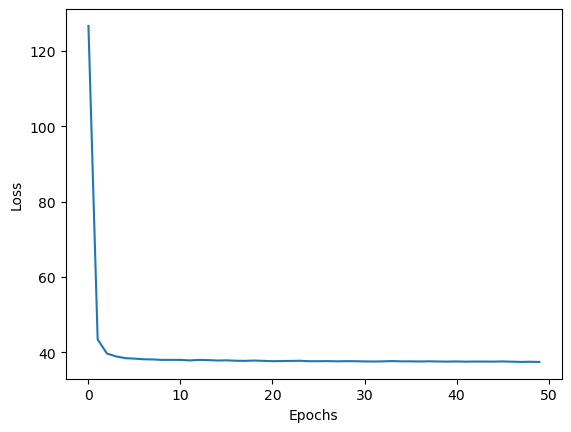

In [153]:
# Train the model for 50 epochs
name = 'pnn_80_25_1_E'
biome = 7

valbiomeDictLAI[biome][name]['history'] = valbiomeDictLAI[biome][name]['model'].fit(calbiomeDictLAI[biome]['X_train'].to_numpy(), calbiomeDictLAI[biome]['y_train'].to_numpy(), epochs=50, verbose=1)

plt.plot(valbiomeDictLAI[biome][name]['history'].history['loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')

_**Figure 2.3.1** Loss convergence trained over 50 epochs for a probabilistic 80-25-1 neural network predicting epistemic uncertainty. Loss converges, indicating the model has been correctly trained._

#### 2.3.5 Making Predictions

In [156]:
name = 'pnn_80_25_1_E'
valSize = [100, 1000]

for size in valSize:
    valbiomeDictLAI[biome][name]['y_model_' + str(size)] = valbiomeDictLAI[biome][name]['model'](valbiomeDictLAI[biome]['X_test_' + str(size)])
    valbiomeDictLAI[biome][name]['mean_' + str(size)] = valbiomeDictLAI[biome][name]['y_model_' + str(size)].mean().numpy().flatten()

    df = pd.DataFrame()
    
    # Making 1000 predictions
    for i in range(1000):
        df[i] = valbiomeDictLAI[biome][name]['model'].predict(valbiomeDictLAI[biome]['X_test_' + str(size)], verbose=0).flatten()

    # Standard deviation over 1000 predictions
    valbiomeDictLAI[biome][name]['stddev_' + str(size)] = df.std(axis=1).to_numpy()

    # Upper and lower bound of confidence interval
    # 2 stddev from the mean gives approx. the 68% confidence interval
    valbiomeDictLAI[biome][name]['lower_' + str(size)] = valbiomeDictLAI[biome][name]['mean_' + str(size)] - valbiomeDictLAI[biome][name]['stddev_' + str(size)]
    valbiomeDictLAI[biome][name]['upper_' + str(size)] = valbiomeDictLAI[biome][name]['mean_' + str(size)] + valbiomeDictLAI[biome][name]['stddev_' + str(size)]

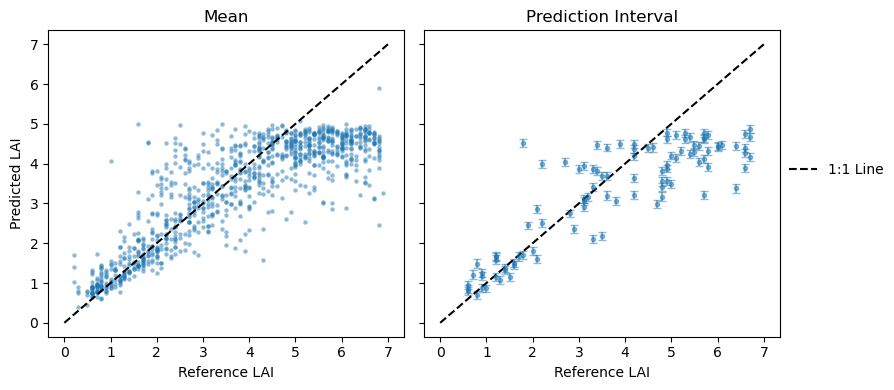

In [313]:
name = 'pnn_80_25_1_E'
biome = 7

fig, axes = plt.subplots(1, 2, sharey=True, figsize=(8,4))

axes[0].scatter(np.divide(valbiomeDictLAI[biome]['y_test_1000'], scaling), np.divide(valbiomeDictLAI[biome][name]['mean_1000'], scaling), s=10, alpha=0.5, lw=0)
axes[0].plot([0, 7], [0, 7], 'k--', label='1:1 Line')

axes[0].set_xlabel("Reference LAI")
axes[0].set_ylabel("Predicted LAI")
axes[0].set_title('Mean')

axes[1].errorbar(np.divide(valbiomeDictLAI[biome]['y_test_100'], scaling), np.divide(valbiomeDictLAI[biome][name]['mean_100'], scaling), np.divide(valbiomeDictLAI[biome][name]['stddev_100'], scaling), fmt='o', ms=3, alpha=0.5, capsize=3)
axes[1].plot([0, 7], [0, 7], 'k--')

axes[1].set_xlabel("Reference LAI")
axes[1].set_title('Prediction Interval')

# plt.xlim([0, 7])
# plt.ylim([0, 7])

fig.tight_layout()

fig.legend(bbox_to_anchor=(1.12, 0.6), loc='centre left', frameon=0)
plt.show()

_**Figure 2.3.2** Predicted LAI with epistemic uncertainity from a probabilistic 80-25-1 neural network in comparison to the reference LAI. Left plot shows a comparison of the means with respect to 1000 validation samples. Right plot shows mean prediction with error bars indicating the 68% confidence interval of each prediction with respect to 100 validation samples. A one-to-one line is plotted to show relatively how well the predictions are. It can be observed that for LAI values greater than 4.5, the model tends to underpredict. This behaviour is expected._

### 2.4 Aleatoric and Epistemic Uncertainty

#### 2.4.1 Defining the Model
To build a network that is capable of modeling both **aleatoric** and **epistemic** uncertainity, we will need to combine **variational layers** with a **distribution layer**. 

Again, the first layer of our model will normalize our input data. The next two layers are the same as our epistemic uncertainity model. We will use the same prior and posterior functions that we have previously defined in [*section 2.3.1*](#2.3.1-Prior-Distribution) and [*section 2.3.2*](#2.3.2-Posterior-Distribution). The third `DenseVariational()` layer is very similar as well except we will specify the number of units with `.params_size()` like we did in the aleatoric model. The last layer is the same as our aleatoric model, where we will return a distribution object.

Our loss function is the same `negloglik` that we defined in [*section 2.2.1*](#2.2.1-Defining-a-log-likelihood-Loss-Function), and we will compile the model in the same way.

In [223]:
# Define the model, negative-log likelihood as the loss function
# and compile the model with the Adam optimizer

name = 'pnn_80_25_1'
biome = 7

valbiomeDictLAI[biome][name] = dict()

valbiomeDictLAI[biome][name]['model'] = tf.keras.Sequential([
    normalizer,
    tfpl.DenseVariational(units=80,
                          make_prior_fn=get_univariate_prior,
                          make_posterior_fn=get_univariate_posterior,
                          kl_weight=1/calbiomeDictLAI[biome]['X_train'].shape[0],
                          kl_use_exact=False,
                          activation='relu'),
    tfpl.DenseVariational(units=25,
                          make_prior_fn=get_univariate_prior,
                          make_posterior_fn=get_univariate_posterior,
                          kl_weight=1/calbiomeDictLAI[biome]['X_train'].shape[0],
                          kl_use_exact=False,
                          activation='relu'),
    tfpl.DenseVariational(units=2,
                          make_prior_fn=get_univariate_prior,
                          make_posterior_fn=get_univariate_posterior,
                          kl_weight=1/calbiomeDictLAI[biome]['X_train'].shape[0],
                          kl_use_exact=False),
    tfp.layers.DistributionLambda(
      lambda t: tfd.Normal(loc=t[..., :1],
                           scale=1e-3 + tf.math.softplus(0.01 * t[...,1:]))),
])

valbiomeDictLAI[biome][name]['model'].compile(loss=negloglik, optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), metrics=[tf.keras.metrics.RootMeanSquaredError()])
valbiomeDictLAI[biome][name]['model'].summary()

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 5)                3         
 n)                                                              
                                                                 
 dense_variational_54 (Dense  (None, 80)               960       
 Variational)                                                    
                                                                 
 dense_variational_55 (Dense  (None, 25)               4050      
 Variational)                                                    
                                                                 
 dense_variational_56 (Dense  (None, 2)                104       
 Variational)                                                    
                                                                 
 distribution_lambda_20 (Dis  ((None, 1),            

#### 2.4.2 Training the Model
We will train the model for 50 epochs and plot the loss function to confirm that the algorithm has converged.

Epoch 1/50
11771/11771 [==============================] - 75s 6ms/step - loss: 93.4440 - root_mean_squared_error: 29.3504
Epoch 2/50
11771/11771 [==============================] - 59s 5ms/step - loss: 3.8937 - root_mean_squared_error: 18.1681
Epoch 3/50
11771/11771 [==============================] - 59s 5ms/step - loss: 3.5354 - root_mean_squared_error: 13.4851
Epoch 4/50
11771/11771 [==============================] - 58s 5ms/step - loss: 3.4954 - root_mean_squared_error: 12.9833
Epoch 5/50
11771/11771 [==============================] - 61s 5ms/step - loss: 3.4722 - root_mean_squared_error: 12.7291
Epoch 6/50
11771/11771 [==============================] - 58s 5ms/step - loss: 3.4947 - root_mean_squared_error: 13.1304
Epoch 7/50
11771/11771 [==============================] - 58s 5ms/step - loss: 3.4291 - root_mean_squared_error: 12.2852
Epoch 8/50
11771/11771 [==============================] - 59s 5ms/step - loss: 3.4239 - root_mean_squared_error: 12.2678
Epoch 9/50
11771/11771 [=======

Text(0, 0.5, 'Loss')

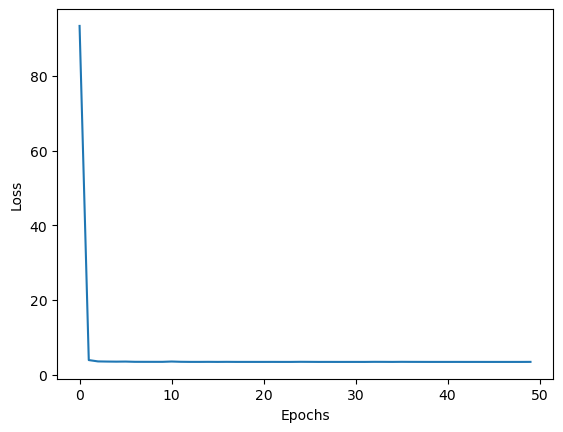

In [224]:
# Train the model for 50 epochs
valbiomeDictLAI[biome][name]['history'] = valbiomeDictLAI[biome][name]['model'].fit(calbiomeDictLAI[biome]['X_train'].to_numpy(), calbiomeDictLAI[biome]['y_train'].to_numpy(), epochs=50, verbose=1)
plt.plot(valbiomeDictLAI[biome][name]['history'].history['loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')

_**Figure 2.4.1** Loss convergence trained over 50 epochs for a probabilistic 80-25-1 neural network predicting aleatoric and epistemic uncertainty. Loss converges, indicating the model has been correctly trained._

#### 2.4.3 Making Predictions

In [225]:
name = 'pnn_80_25_1'
biome = 7

valSize = [100, 1000]

for size in valSize:
    valbiomeDictLAI[biome][name]['y_model_' + str(size)] = valbiomeDictLAI[biome][name]['model'](valbiomeDictLAI[biome]['X_test_' + str(size)])

    # Mean and standard deviation
    valbiomeDictLAI[biome][name]['mean_' + str(size)] = valbiomeDictLAI[biome][name]['y_model_' + str(size)].mean().numpy().flatten()
    valbiomeDictLAI[biome][name]['stddev_' + str(size)] = valbiomeDictLAI[biome][name]['y_model_' + str(size)].stddev().numpy().flatten()

    # Upper and lower bound of confidence interval
    # 1 stddev from the mean gives approx. the 68% confidence interval
    valbiomeDictLAI[biome][name]['lower_' + str(size)] = valbiomeDictLAI[biome][name]['mean_' + str(size)] - valbiomeDictLAI[biome][name]['stddev_' + str(size)]
    valbiomeDictLAI[biome][name]['upper_' + str(size)] = valbiomeDictLAI[biome][name]['mean_' + str(size)] + valbiomeDictLAI[biome][name]['stddev_' + str(size)]

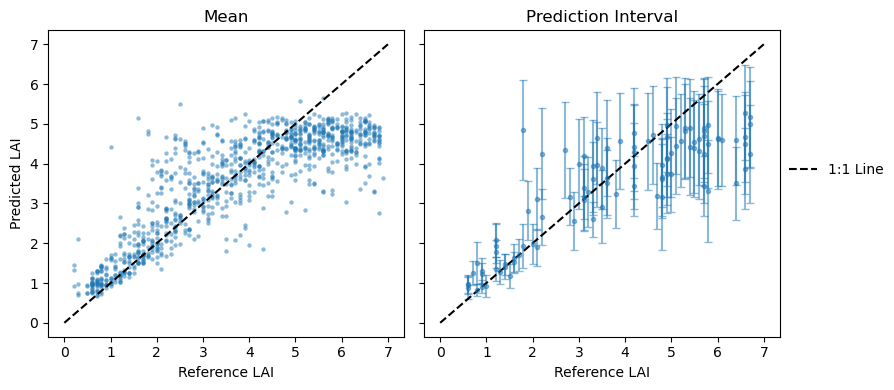

In [226]:
name = 'pnn_80_25_1'
biome = 7

fig, axes = plt.subplots(1, 2, sharey=True, figsize=(8,4))

axes[0].scatter(np.divide(valbiomeDictLAI[biome]['y_test_1000'], scaling), np.divide(valbiomeDictLAI[biome][name]['mean_1000'], scaling), s=10, alpha=0.5, lw=0)
axes[0].plot([0, 7], [0, 7], 'k--', label='1:1 Line')

axes[0].set_xlabel("Reference LAI")
axes[0].set_ylabel("Predicted LAI")
axes[0].set_title('Mean')

axes[1].errorbar(np.divide(valbiomeDictLAI[biome]['y_test_100'], scaling), np.divide(valbiomeDictLAI[biome][name]['mean_100'], scaling), np.divide(valbiomeDictLAI[biome][name]['stddev_100'], scaling), fmt='o', ms=3, alpha=0.5, capsize=3)
axes[1].plot([0, 7], [0, 7], 'k--')

axes[1].set_xlabel("Reference LAI")
axes[1].set_title('Prediction Interval')

# plt.xlim([0, 7])
# plt.ylim([0, 7])

fig.tight_layout()

fig.legend(bbox_to_anchor=(1.12, 0.6), loc='centre left', frameon=0)
plt.show()

_**Figure 2.4.2** Predicted LAI with aleatoric and epistemic uncertainity from a probabilistic 80-25-1 neural network in comparison to the reference LAI. Left plot shows a comparison of the means with respect to 1000 validation samples. Right plot shows mean prediction with error bars indicating the 68% confidence interval of each prediction with respect to 100 validation samples. A one-to-one line is plotted to show relatively how well the predictions are. It can be observed that for LAI values greater than 4.5, the model tends to underpredict. This behaviour is expected._

### 2.5 Multivariate Distrubtion: Regular Neural Network

#### 2.5.0 Background
In our previous neural network estimating epistemic uncertainity, we defined the prior and posterior using a **univariate normal distribution**, which is described using just the mean and varaince. However, our input data consists of 5 regressors, where each regressor could influence the others. In this case, it would be appropriate to consider a **multivariate distribution**. In contrast to a univariate normal distribution, a multivariate normal distribution considers a third variable; the **correlation between each pair of random variables**. 

More details on how to define the prior and posterior with a multivariate distribution will be explained in [*section 2.7*](#2.7-Multivariate-Distribution:-Epistemic-Uncertainty).

One important thing to note is that since we need to compute this correlation, the number of parameters to train increases exponentially. Because of this, we do not have enough training data to train a large 80-25-1 network. Hence, to make comparisons between a model using a univariate distrubtion and one using a multivariate distribution, we will use a smaller 8-2-1 model for the multivariate distributed model.

#### 2.5.1 Defining the Model
There is no difference in this model compared to the one we defined in [*section 2.1.2*](#2.1.2-Defining-the-Model) apart from the number of neurons in each layer. Refer to [*section 2.1.2*](#2.1.2-Defining-the-Model) for details on each layer.

In [54]:
# Define the model, negative-log likelihood as the loss function
# and compile the model with the Adam optimizer

name = 'nn_8_2_1'
biome = 7

# Create a new dictionary to save the Network
valbiomeDictLAI[biome][name] = dict()

valbiomeDictLAI[biome][name]['model'] = tf.keras.Sequential([
    normalizer,
    layers.Dense(units=8, activation='relu'),
    layers.Dense(units=2, activation='relu'),
    layers.Dense(units=1)
])

# Compile the model with the specified loss and optimizer functions
valbiomeDictLAI[biome][name]['model'].compile(loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), metrics=[tf.keras.metrics.RootMeanSquaredError()])
valbiomeDictLAI[biome][name]['model'].summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 5)                3         
 n)                                                              
                                                                 
 dense_6 (Dense)             (None, 8)                 48        
                                                                 
 dense_7 (Dense)             (None, 2)                 18        
                                                                 
 dense_8 (Dense)             (None, 1)                 3         
                                                                 
Total params: 72
Trainable params: 69
Non-trainable params: 3
_________________________________________________________________


#### 2.5.2 Training the Model

Epoch 1/50
11771/11771 [==============================] - 40s 3ms/step - loss: 105.6636 - root_mean_squared_error: 10.2793
Epoch 2/50
11771/11771 [==============================] - 36s 3ms/step - loss: 90.6702 - root_mean_squared_error: 9.5221
Epoch 3/50
11771/11771 [==============================] - 32s 3ms/step - loss: 87.0535 - root_mean_squared_error: 9.3302
Epoch 4/50
11771/11771 [==============================] - 33s 3ms/step - loss: 81.5816 - root_mean_squared_error: 9.0323
Epoch 5/50
11771/11771 [==============================] - 33s 3ms/step - loss: 79.8378 - root_mean_squared_error: 8.9352
Epoch 6/50
11771/11771 [==============================] - 34s 3ms/step - loss: 77.6092 - root_mean_squared_error: 8.8096
Epoch 7/50
11771/11771 [==============================] - 55s 5ms/step - loss: 76.9044 - root_mean_squared_error: 8.7695
Epoch 8/50
11771/11771 [==============================] - 81s 7ms/step - loss: 76.5132 - root_mean_squared_error: 8.7472
Epoch 9/50
11771/11771 [======

Text(0, 0.5, 'Loss')

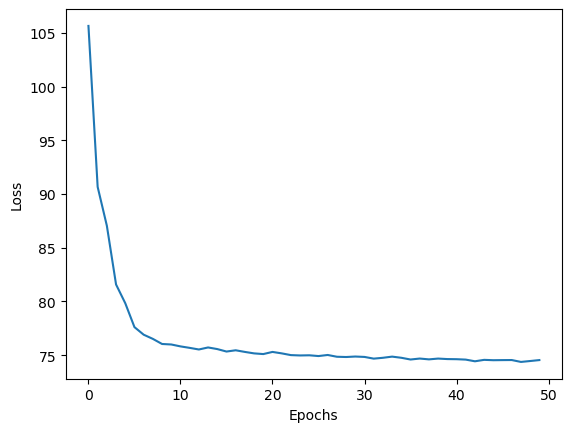

In [55]:
# Train the model for 50 epochs
name = 'nn_8_2_1'
biome = 7

valbiomeDictLAI[biome][name]['history'] = valbiomeDictLAI[biome][name]['model'].fit(calbiomeDictLAI[biome]['X_train'].to_numpy(), calbiomeDictLAI[biome]['y_train'].to_numpy(), epochs=50, verbose=1)
plt.plot(valbiomeDictLAI[biome][name]['history'].history['loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')

_**Figure 2.5.1** Loss convergence trained over 50 epochs for a regular 8-2-1 neural network predicting aleatoric uncertainty. Loss converges, indicating the model has been correctly trained._

#### 2.5.3 Making Predictions

In [56]:
name = 'nn_8_2_1'
biome = 7

valSize = [100, 1000]

for size in valSize: 
    valbiomeDictLAI[biome][name]['y_pred_' + str(size)] = valbiomeDictLAI[biome][name]['model'].predict(valbiomeDictLAI[biome]['X_test_' + str(size)]).flatten()

32/32 [==============================] - 0s 4ms/step


32/32 [==============================] - 1s 9ms/step


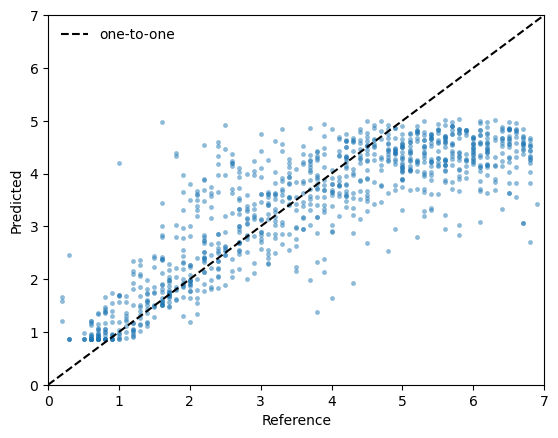

In [368]:
name = 'nn_8_2_1'
biome = 7

valbiomeDictLAI[biome][name]['y_pred_1000'] = valbiomeDictLAI[biome][name]['model'].predict(valbiomeDictLAI[biome]['X_test_1000']).flatten()

plt.scatter(np.divide(valbiomeDictLAI[biome]['y_test_1000'], scaling), np.divide(valbiomeDictLAI[biome][name]['y_pred_1000'], scaling), alpha=0.5, s=12, lw=0)
plt.plot([0, 7], [0, 7], 'k--', label='one-to-one')

plt.xlabel("Reference")
plt.ylabel("Predicted")

plt.xlim([0, 7])
plt.ylim([0, 7])
plt.legend(frameon=0)
plt.show()

_**Figure 2.5.2** Predicted LAI from a regular 8-2-1 neural network in comparison to the reference LAI for 1000 validation samples. A one-to-one is plotted to show relatively how well the predictions are. It can be observed that for LAI values greater than 4.5, the model tends to underpredict. This behaviour is expected._

### 2.6 Multivariate Distribution: Aleatoric Uncertainty

#### 2.6.1 Defining the Model
The model is defined in the same way as the model in [*section 2.2.2*](#2.2.2-Defining-the-Model). Refer to [*section 2.2.2*](#2.2.2-Defining-the-Model) for details.

In [ ]:
# Define the model, negative-log likelihood as the loss function
# and compile the model with the Adam optimizer

name = 'pnn_8_2_1_A'
biome = 7

valbiomeDictLAI[biome][name] = dict()

valbiomeDictLAI[biome][name]['model'] = tf.keras.Sequential([
    normalizer,
    layers.Dense(units=8, activation='relu'),
    layers.Dense(units=2, activation='relu'),
    layers.Dense(units=2),
    tfpl.DistributionLambda(
      lambda t: tfd.Normal(loc=t[..., :1],
                           scale=1e-3 + tf.math.softplus(0.01 * t[...,1:]))),
])

valbiomeDictLAI[biome][name]['model'].compile(loss=negloglik, optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), metrics=[tf.keras.metrics.RootMeanSquaredError()])
valbiomeDictLAI[biome][name]['model'].summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 5)                3         
 n)                                                              
                                                                 
 dense_9 (Dense)             (None, 8)                 48        
                                                                 
 dense_10 (Dense)            (None, 2)                 18        
                                                                 
 dense_11 (Dense)            (None, 2)                 6         
                                                                 
 distribution_lambda_3 (Dist  ((None, 1),              0         
 ributionLambda)              (None, 1))                         
                                                                 
Total params: 75
Trainable params: 72
Non-trainable pa

#### 2.6.2 Training the Model

Epoch 1/50
11771/11771 [==============================] - 59s 5ms/step - loss: 15.2151 - root_mean_squared_error: 17.0311
Epoch 2/50
11771/11771 [==============================] - 58s 5ms/step - loss: 3.6737 - root_mean_squared_error: 14.8892
Epoch 3/50
11771/11771 [==============================] - 62s 5ms/step - loss: 3.5767 - root_mean_squared_error: 14.1574
Epoch 4/50
11771/11771 [==============================] - 58s 5ms/step - loss: 3.5619 - root_mean_squared_error: 14.1532
Epoch 5/50
11771/11771 [==============================] - 59s 5ms/step - loss: 3.5569 - root_mean_squared_error: 14.1456
Epoch 6/50
11771/11771 [==============================] - 55s 5ms/step - loss: 3.5477 - root_mean_squared_error: 14.0382
Epoch 7/50
11771/11771 [==============================] - 57s 5ms/step - loss: 3.5044 - root_mean_squared_error: 13.5492
Epoch 8/50
11771/11771 [==============================] - 58s 5ms/step - loss: 3.4795 - root_mean_squared_error: 13.2240
Epoch 9/50
11771/11771 [=======

Text(0, 0.5, 'Loss')

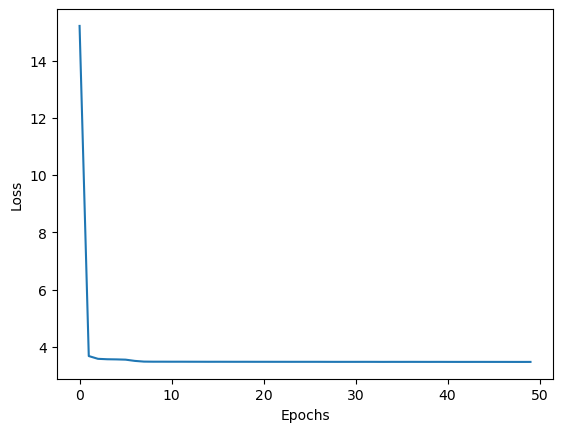

In [ ]:
# Train the model for 50 epochs
name = 'pnn_8_2_1_A'
biome = 7

valbiomeDictLAI[biome][name]['history'] = valbiomeDictLAI[biome][name]['model'].fit(calbiomeDictLAI[biome]['X_train'].to_numpy(), calbiomeDictLAI[biome]['y_train'].to_numpy(), epochs=50, verbose=1)

plt.plot(valbiomeDictLAI[biome][name]['history'].history['loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')

_**Figure 2.6.1** Loss convergence trained over 50 epochs for a probabilistic 8-2-1 neural network predicting aleatoric uncertainty. Loss converges, indicating the model has been correctly trained._

#### 2.6.3 Making Predictions

In [317]:
name = 'pnn_8_2_1_A'
biome = 7

valSize = [100, 1000]

for size in valSize:
    valbiomeDictLAI[biome][name]['y_model_' + str(size)] = valbiomeDictLAI[biome][name]['model'](valbiomeDictLAI[biome]['X_test_' + str(size)])

     # Mean and standard deviation
    valbiomeDictLAI[biome][name]['mean_' + str(size)] = valbiomeDictLAI[biome][name]['y_model_' + str(size)].mean().numpy().flatten()
    valbiomeDictLAI[biome][name]['stddev_' + str(size)] = valbiomeDictLAI[biome][name]['y_model_' + str(size)].stddev().numpy().flatten()

    # Upper and lower bound of confidence interval
    # 1 stddev from the mean gives approx. the 68% confidence interval
    valbiomeDictLAI[biome][name]['lower_' + str(size)] = valbiomeDictLAI[biome][name]['mean_' + str(size)] - valbiomeDictLAI[biome][name]['stddev_' + str(size)]
    valbiomeDictLAI[biome][name]['upper_' + str(size)] = valbiomeDictLAI[biome][name]['mean_' + str(size)] + valbiomeDictLAI[biome][name]['stddev_' + str(size)]

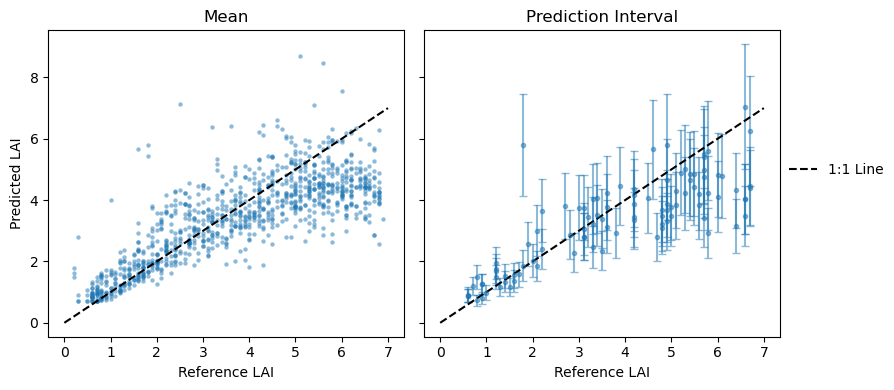

In [318]:
name = 'pnn_8_2_1_A'
biome = 7

fig, axes = plt.subplots(1, 2, sharey=True, figsize=(8,4))

axes[0].scatter(np.divide(valbiomeDictLAI[biome]['y_test_1000'], scaling), np.divide(valbiomeDictLAI[biome][name]['mean_1000'], scaling), s=10, alpha=0.5, lw=0)
axes[0].plot([0, 7], [0, 7], 'k--', label='1:1 Line')

axes[0].set_xlabel("Reference LAI")
axes[0].set_ylabel("Predicted LAI")
axes[0].set_title('Mean')

axes[1].errorbar(np.divide(valbiomeDictLAI[biome]['y_test_100'], scaling), np.divide(valbiomeDictLAI[biome][name]['mean_100'], scaling), np.divide(valbiomeDictLAI[biome][name]['stddev_100'], scaling), fmt='o', ms=3, alpha=0.5, capsize=3)
axes[1].plot([0, 7], [0, 7], 'k--')

axes[1].set_xlabel("Reference LAI")
axes[1].set_title('Prediction Interval')

# plt.xlim([0, 7])
# plt.ylim([0, 7])

fig.tight_layout()

fig.legend(bbox_to_anchor=(1.12, 0.6), loc='centre left', frameon=0)
plt.show()

_**Figure 2.6.2** Predicted LAI with aleatoric uncertainity from a probabilistic 8-2-1 neural network in comparison to the reference LAI. Left plot shows a comparison of the means with respect to 1000 validation samples. Right plot shows mean predictions with error bars indicating the 68% confidence interval of each prediction with respect to 100 validation samples. A one-to-one is plotted to show relatively how well the predictions are. It can be observed that for LAI values greater than 4.5, the model tends to underpredict. This behaviour is expected._

### 2.7 Multivariate Distribution: Epistemic Uncertainty

#### 2.7.0 Background Information
This is where we will implement the multivariate distribution and will differ from [*section 2.3*](#2.3-Epistemic-Uncertainty).

#### 2.7.1 Prior Distribution
To define the prior, we used `MultivariateNormalDiag()` (a multivariate normal distribution wtih a diagonal covariance matrix), with a specified mean and a standard deviation of 1. Then we use the `DistrubtionLambda()` function to transform the distribution object into a Keras-compatible layer, and inject it into a `keras.Sequantial()` model. 

In [408]:
# Prior - diagonal MVN ~ N(0, 1)
def get_multivariate_prior(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size
    return tf.keras.Sequential([
        tfpl.DistributionLambda(
            lambda t: tfd.MultivariateNormalDiag(loc=tf.zeros(n), scale_diag=tf.ones(n)))
    ])

#### 2.7.2 Posterior Distribution
Unlike the prior distribution, we want the posterior to be trainable. We will use a multivariate Gaussian distribution, but allows off-diagonal elements in the covariance matrix to be non-zero. 
There are 3 ways to parameterize such a distribution:
1. in terms of a positive definite covariance matrix
2. via a positive definite precision matrix
3. with a lower-triangular matrix with positive-valued diagonal entries (can be obtained via **Cholesky decomposition**)

In this case, we use method 3 with `MultivariateNromalTriL()` (*TriL* stands for *triangular lower*). We will use `VariableLayer()` that generates a trainable variable to parametrize `MultivariateNromalTriL()`, using `.params_size()` to get a precise number of parameters necessary.

In [409]:
# Posterior
def get_multivariate_posterior(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size
    return tf.keras.Sequential([
        tfpl.VariableLayer(tfpl.MultivariateNormalTriL.params_size(n), dtype=dtype),
        tfpl.MultivariateNormalTriL(n)
    ])

#### 2.7.3 Defining the Model
The model is defined in the same way as in [*section 2.3.3*](#2.3.3-Defining-the-Model) but with our newly defined prior and posterior functions.

In [410]:
# Define the model, negative-log likelihood as the loss function
# and compile the model with the Adam optimizer

name = 'pnn_8_2_1_multi_E'
biome = 7

valbiomeDictLAI[biome][name] = dict()

valbiomeDictLAI[biome][name]['model'] = tf.keras.Sequential([
    normalizer,
    tfpl.DenseVariational(units=8,
                          make_prior_fn=get_multivariate_prior,
                          make_posterior_fn=get_multivariate_posterior,
                          kl_weight=1/calbiomeDictLAI[biome]['X_train'].shape[0],
                          kl_use_exact=False,
                          activation='relu'),
    tfpl.DenseVariational(units=2,
                          make_prior_fn=get_multivariate_prior,
                          make_posterior_fn=get_multivariate_posterior,
                          kl_weight=1/calbiomeDictLAI[biome]['X_train'].shape[0],
                          kl_use_exact=False,
                          activation='relu'),
    tfpl.DenseVariational(units=1,
                          make_prior_fn=get_multivariate_prior,
                          make_posterior_fn=get_multivariate_posterior,
                          kl_weight=1/calbiomeDictLAI[biome]['X_train'].shape[0],
                          kl_use_exact=False),
    tfpl.DistributionLambda(lambda t: tfd.Normal(loc=t, scale=1.))
])

valbiomeDictLAI[biome][name]['model'].compile(loss=negloglik, optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), metrics=[tf.keras.metrics.RootMeanSquaredError()])
valbiomeDictLAI[biome][name]['model'].summary()

Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 5)                3         
 n)                                                              
                                                                 
 dense_variational_78 (Dense  (None, 8)                1224      
 Variational)                                                    
                                                                 
 dense_variational_79 (Dense  (None, 2)                189       
 Variational)                                                    
                                                                 
 dense_variational_80 (Dense  (None, 1)                9         
 Variational)                                                    
                                                                 
 distribution_lambda_28 (Dis  ((None, 1),            

#### 2.7.4 Training the Model

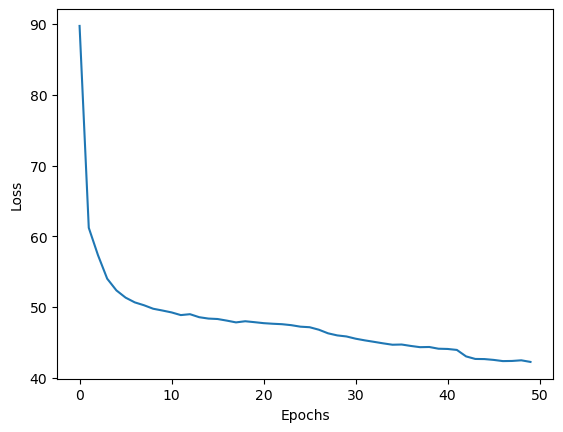

In [429]:
# Train the model for 50 epochs
name = 'pnn_8_2_1_multi_E'
biome = 7

valbiomeDictLAI[biome][name]['history'] = valbiomeDictLAI[biome][name]['model'].fit(calbiomeDictLAI[biome]['X_train'].to_numpy(), calbiomeDictLAI[biome]['y_train'].to_numpy(), epochs=50, verbose=1)
plt.plot(valbiomeDictLAI[biome][name]['history'].history['loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

_**Figure 2.7.1** Loss convergence trained over 50 epochs for a probabilistic 8-2-1 neural network predicting epistemic uncertainty. Loss converges, indicating the model has been correctly trained._

#### 2.7.5 Making Predictions

In [412]:
name = 'pnn_8_2_1_multi_E'
biome = 7

valSize = [100, 1000]

for size in valSize:
    valbiomeDictLAI[biome][name]['y_model_' + str(size)] = valbiomeDictLAI[biome][name]['model'](valbiomeDictLAI[biome]['X_test_' + str(size)])
    valbiomeDictLAI[biome][name]['mean_' + str(size)] = valbiomeDictLAI[biome][name]['y_model_' + str(size)].mean().numpy().flatten()

    df = pd.DataFrame()
    
    # Making 1000 predictions
    for i in range(1000):
        df[i] = valbiomeDictLAI[biome][name]['model'].predict(valbiomeDictLAI[biome]['X_test_' + str(size)], verbose=0).flatten()

    # Standard deviation over 1000 predictions
    valbiomeDictLAI[biome][name]['stddev_' + str(size)] = df.std(axis=1).to_numpy()

    # Upper and lower bound of confidence interval
    valbiomeDictLAI[biome][name]['lower_' + str(size)] = valbiomeDictLAI[biome][name]['mean_' + str(size)] - valbiomeDictLAI[biome][name]['stddev_' + str(size)]
    valbiomeDictLAI[biome][name]['upper_' + str(size)] = valbiomeDictLAI[biome][name]['mean_' + str(size)] + valbiomeDictLAI[biome][name]['stddev_' + str(size)]

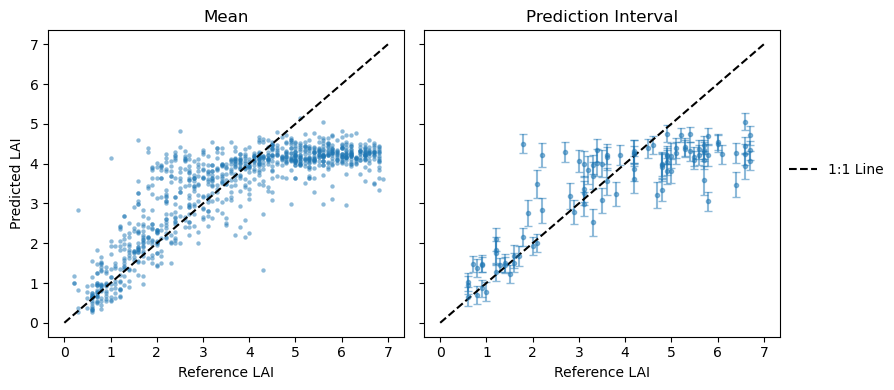

In [430]:
name = 'pnn_8_2_1_multi_E'
biome = 7

fig, axes = plt.subplots(1, 2, sharey=True, figsize=(8,4))

axes[0].scatter(np.divide(valbiomeDictLAI[biome]['y_test_1000'], scaling), np.divide(valbiomeDictLAI[biome][name]['mean_1000'], scaling), s=10, alpha=0.5, lw=0)
axes[0].plot([0, 7], [0, 7], 'k--', label='1:1 Line')

axes[0].set_xlabel("Reference LAI")
axes[0].set_ylabel("Predicted LAI")
axes[0].set_title('Mean')

axes[1].errorbar(np.divide(valbiomeDictLAI[biome]['y_test_100'], scaling), np.divide(valbiomeDictLAI[biome][name]['mean_100'], scaling), np.divide(valbiomeDictLAI[biome][name]['stddev_100'], scaling), fmt='o', ms=3, alpha=0.5, capsize=3)
axes[1].plot([0, 7], [0, 7], 'k--')

axes[1].set_xlabel("Reference LAI")
axes[1].set_title('Prediction Interval')

# plt.xlim([0, 7])
# plt.ylim([0, 7])

fig.tight_layout()

fig.legend(bbox_to_anchor=(1.12, 0.6), loc='centre left', frameon=0)
plt.show()

_**Figure 2.7.2** Predicted LAI with epistemic uncertainity from a probabilistic 8-2-1 neural network using a multivariate distribution in comparison to the reference LAI. Left plot shows a comparison of the means with respect to 1000 validation samples. Right plot shows mean predictions with error bars indicating the 68% confidence interval of each prediction with respect to 100 validation samples. A one-to-one is plotted to show relatively how well the predictions are. It can be observed that for LAI values greater than 4.5, the model tends to underpredict. This behaviour is expected._

### 2.8 Multivariate Distribution: Aleatoric and Epistemic Uncertainty

#### 2.8.1 Defining the Model
The model is defined in the same way as in [*section 2.4.1*](#2.4.1-Defining-the-Model) except using our newly defined prior and posterior from  [*section 2.7.1*](#2.7.1-Prior-Distribution) and [*section 2.7.2*](#2.7.2-Posterior-Distribution).

In [415]:
# Define the model, negative-log likelihood as the loss function
# and compile the model with the Adam optimizer

name = 'pnn_8_2_1_multi'
biome = 7

valbiomeDictLAI[biome][name] = dict()

valbiomeDictLAI[biome][name]['model'] = tf.keras.Sequential([
    normalizer,
    tfpl.DenseVariational(units=8,
                          make_prior_fn=get_multivariate_prior,
                          make_posterior_fn=get_multivariate_posterior,
                          kl_weight=1/calbiomeDictLAI[biome]['X_train'].shape[0],
                          kl_use_exact=False,
                          activation='relu'),
    tfpl.DenseVariational(units=2,
                          make_prior_fn=get_multivariate_prior,
                          make_posterior_fn=get_multivariate_posterior,
                          kl_weight=1/calbiomeDictLAI[biome]['X_train'].shape[0],
                          kl_use_exact=False,
                          activation='relu'),
    tfpl.DenseVariational(units=2,
                          make_prior_fn=get_multivariate_prior,
                          make_posterior_fn=get_multivariate_posterior,
                          kl_weight=1/calbiomeDictLAI[biome]['X_train'].shape[0],
                          kl_use_exact=False),
    tfpl.DistributionLambda(
      lambda t: tfd.Normal(loc=t[..., :1],
                           scale=1e-3 + tf.math.softplus(0.01 * t[...,1:]))),
])

valbiomeDictLAI[biome][name]['model'].compile(loss=negloglik, optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), metrics=[tf.keras.metrics.RootMeanSquaredError()])
valbiomeDictLAI[biome][name]['model'].summary()

Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 5)                3         
 n)                                                              
                                                                 
 dense_variational_81 (Dense  (None, 8)                1224      
 Variational)                                                    
                                                                 
 dense_variational_82 (Dense  (None, 2)                189       
 Variational)                                                    
                                                                 
 dense_variational_83 (Dense  (None, 2)                27        
 Variational)                                                    
                                                                 
 distribution_lambda_29 (Dis  ((None, 1),            

#### 2.8.2 Training the Model

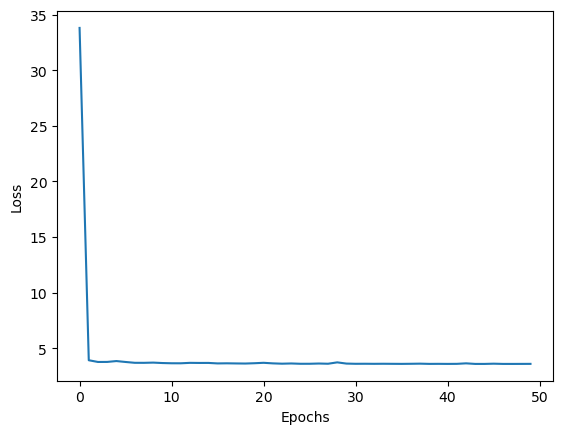

In [425]:
name = 'pnn_8_2_1_multi'
biome = 7

# Train the model for 50 epochs
valbiomeDictLAI[biome][name]['history'] = valbiomeDictLAI[biome][name]['model'].fit(calbiomeDictLAI[biome]['X_train'].to_numpy(), calbiomeDictLAI[biome]['y_train'].to_numpy(), epochs=50, verbose=1)
plt.plot(valbiomeDictLAI[biome][name]['history'].history['loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

_**Figure 2.8.1** Loss convergence trained over 50 epochs for a probabilistic 8-2-1 neural network predicting aleatoric and epistemic uncertainty. Loss converges, indicating the model has been correctly trained._

#### 2.8.3 Making Predictions

In [417]:
name = 'pnn_8_2_1_multi'
biome = 7

valSize = [100, 1000]

for size in valSize:
    valbiomeDictLAI[biome][name]['y_model_' + str(size)] = valbiomeDictLAI[biome][name]['model'](valbiomeDictLAI[biome]['X_test_' + str(size)])

    # Prediction mean and stddev
    valbiomeDictLAI[biome][name]['mean_' + str(size)] = valbiomeDictLAI[biome][name]['y_model_' + str(size)].mean().numpy().flatten()
    valbiomeDictLAI[biome][name]['stddev_' + str(size)] = valbiomeDictLAI[biome][name]['y_model_' + str(size)].stddev().numpy().flatten()

    # Upper and lower bound of confidence interval
    # 1 stddev from the mean gives approx. the 68% confidence interval
    valbiomeDictLAI[biome][name]['lower_' + str(size)] = valbiomeDictLAI[biome][name]['mean_' + str(size)] - valbiomeDictLAI[biome][name]['stddev_' + str(size)]
    valbiomeDictLAI[biome][name]['upper_' + str(size)] = valbiomeDictLAI[biome][name]['mean_' + str(size)] + valbiomeDictLAI[biome][name]['stddev_' + str(size)]

<a id='Figure-2.8.2'></a>

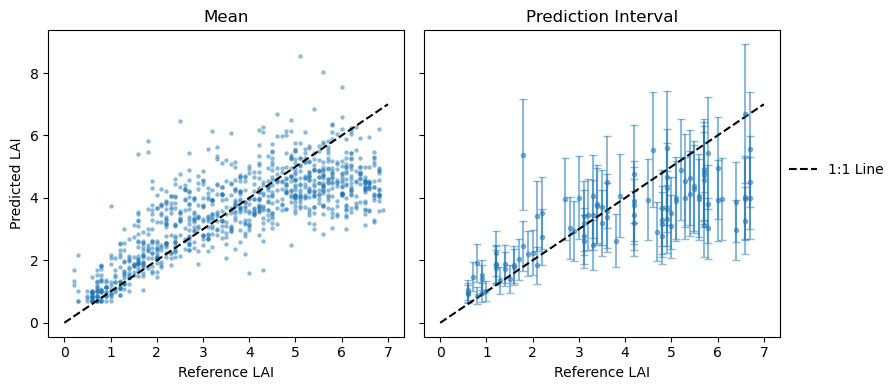

In [426]:
name = 'pnn_8_2_1_multi'
biome = 7

fig, axes = plt.subplots(1, 2, sharey=True, figsize=(8,4))

axes[0].scatter(np.divide(valbiomeDictLAI[biome]['y_test_1000'], scaling), np.divide(valbiomeDictLAI[biome][name]['mean_1000'], scaling), s=10, alpha=0.5, lw=0)
axes[0].plot([0, 7], [0, 7], 'k--', label='1:1 Line')

axes[0].set_xlabel("Reference LAI")
axes[0].set_ylabel("Predicted LAI")
axes[0].set_title('Mean')

axes[1].errorbar(np.divide(valbiomeDictLAI[biome]['y_test_100'], scaling), np.divide(valbiomeDictLAI[biome][name]['mean_100'], scaling), np.divide(valbiomeDictLAI[biome][name]['stddev_100'], scaling), fmt='o', ms=3, alpha=0.5, capsize=3)
axes[1].plot([0, 7], [0, 7], 'k--')

axes[1].set_xlabel("Reference LAI")
axes[1].set_title('Prediction Interval')

# plt.xlim([0, 7])
# plt.ylim([0, 7])

fig.tight_layout()

fig.legend(bbox_to_anchor=(1.12, 0.6), loc='centre left', frameon=0)
plt.show()

_**Figure 2.8.2** Predicted LAI with aleatoric and epistemic uncertainity from a probabilistic 8-2-1 neural network using a multivariate distribution in comparison to the reference LAI. Left plot shows a comparison of the means with respect to 1000 valiadtion samples. Right plot shows mean predictions with error bars indicating the 68% confidence interval of each prediction with respect to 100 validation samples. A one-to-one is plotted to show relatively how well the predictions are. It can be observed that for LAI values greater than 4.5, the model tends to underpredict. This behaviour is expected._

### 2.9 Univariate Distribution: Epistemic

#### 2.9.0 Background Information
We will define and train an 8-2-1 probabilistic neural network with univariate distributions in the [prior](#2.3.1-Prior-Distribution) and [posterior](#2.3.2-Posterior-Distribution) to compare with the 8-2-1 network using multivariate distribtions.

#### 2.9.1 Defining the Model

In [443]:
# Define the model, negative-log likelihood as the loss function
# and compile the model with the Adam optimizer

name = 'pnn_8_2_1_uni_E'
biome = 7

valbiomeDictLAI[biome][name] = dict()

valbiomeDictLAI[biome][name]['model'] = tf.keras.Sequential([
    normalizer,
    tfpl.DenseVariational(units=8,
                          make_prior_fn=get_univariate_prior,
                          make_posterior_fn=get_univariate_posterior,
                          kl_weight=1/calbiomeDictLAI[biome]['X_train'].shape[0],
                          kl_use_exact=False,
                          activation='relu'),
    tfpl.DenseVariational(units=2,
                          make_prior_fn=get_univariate_prior,
                          make_posterior_fn=get_univariate_posterior,
                          kl_weight=1/calbiomeDictLAI[biome]['X_train'].shape[0],
                          kl_use_exact=False,
                          activation='relu'),
    tfpl.DenseVariational(units=1,
                          make_prior_fn=get_univariate_prior,
                          make_posterior_fn=get_univariate_posterior,
                          kl_weight=1/calbiomeDictLAI[biome]['X_train'].shape[0],
                          kl_use_exact=False),
    tfpl.DistributionLambda(lambda t: tfd.Normal(loc=t, scale=1.))
])

valbiomeDictLAI[biome][name]['model'].compile(loss=negloglik, optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), metrics=[tf.keras.metrics.RootMeanSquaredError()])
valbiomeDictLAI[biome][name]['model'].summary()

Model: "sequential_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 5)                3         
 n)                                                              
                                                                 
 dense_variational_84 (Dense  (None, 8)                96        
 Variational)                                                    
                                                                 
 dense_variational_85 (Dense  (None, 2)                36        
 Variational)                                                    
                                                                 
 dense_variational_86 (Dense  (None, 1)                6         
 Variational)                                                    
                                                                 
 distribution_lambda_30 (Dis  ((None, 1),            

#### 2.9.2 Training the Model

In [444]:
name = 'pnn_8_2_1_uni_E'
biome = 7

# Train the model for 50 epochs
valbiomeDictLAI[biome][name]['history'] = valbiomeDictLAI[biome][name]['model'].fit(calbiomeDictLAI[biome]['X_train'].to_numpy(), calbiomeDictLAI[biome]['y_train'].to_numpy(), epochs=50, verbose=1)
plt.plot(valbiomeDictLAI[biome][name]['history'].history['loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')

Epoch 1/50
11771/11771 [==============================] - 30s 2ms/step - loss: 80.8486 - root_mean_squared_error: 12.6858
Epoch 2/50
11771/11771 [==============================] - 28s 2ms/step - loss: 44.6267 - root_mean_squared_error: 9.4056
Epoch 3/50
11771/11771 [==============================] - 28s 2ms/step - loss: 41.2170 - root_mean_squared_error: 9.0335
Epoch 4/50
11771/11771 [==============================] - 28s 2ms/step - loss: 40.3282 - root_mean_squared_error: 8.9360
Epoch 5/50
11771/11771 [==============================] - 29s 2ms/step - loss: 40.0711 - root_mean_squared_error: 8.9060
Epoch 6/50
11771/11771 [==============================] - 32s 3ms/step - loss: 39.9409 - root_mean_squared_error: 8.8904
Epoch 7/50
11771/11771 [==============================] - 35s 3ms/step - loss: 39.8087 - root_mean_squared_error: 8.8717
Epoch 8/50
11771/11771 [==============================] - 41s 3ms/step - loss: 39.7100 - root_mean_squared_error: 8.8643
Epoch 9/50
11771/11771 [=======

Text(0, 0.5, 'Loss')

_**Figure 2.9.1** Loss convergence trained over 50 epochs for a probabilistic 8-2-1 neural network predicting aleatoric and epistemic uncertainty. Loss converges, indicating the model has been correctly trained._

#### 2.9.3 Making Predictions

In [445]:
name = 'pnn_8_2_1_uni_E'
biome = 7

valSize = [100, 1000]

for size in valSize:
    valbiomeDictLAI[biome][name]['y_model_' + str(size)] = valbiomeDictLAI[biome][name]['model'](valbiomeDictLAI[biome]['X_test_' + str(size)])
    valbiomeDictLAI[biome][name]['mean_' + str(size)] = valbiomeDictLAI[biome][name]['y_model_' + str(size)].mean().numpy().flatten()

    df = pd.DataFrame()
    
    # Making 1000 predictions
    for i in range(1000):
        df[i] = valbiomeDictLAI[biome][name]['model'].predict(valbiomeDictLAI[biome]['X_test_' + str(size)], verbose=0).flatten()

    # Standard deviation over 1000 predictions
    valbiomeDictLAI[biome][name]['stddev_' + str(size)] = df.std(axis=1).to_numpy()

    # Upper and lower bound of confidence interval
    valbiomeDictLAI[biome][name]['lower_' + str(size)] = valbiomeDictLAI[biome][name]['mean_' + str(size)] - valbiomeDictLAI[biome][name]['stddev_' + str(size)]
    valbiomeDictLAI[biome][name]['upper_' + str(size)] = valbiomeDictLAI[biome][name]['mean_' + str(size)] + valbiomeDictLAI[biome][name]['stddev_' + str(size)]

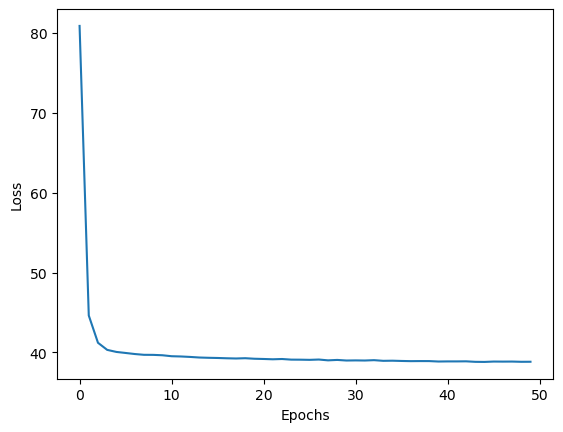

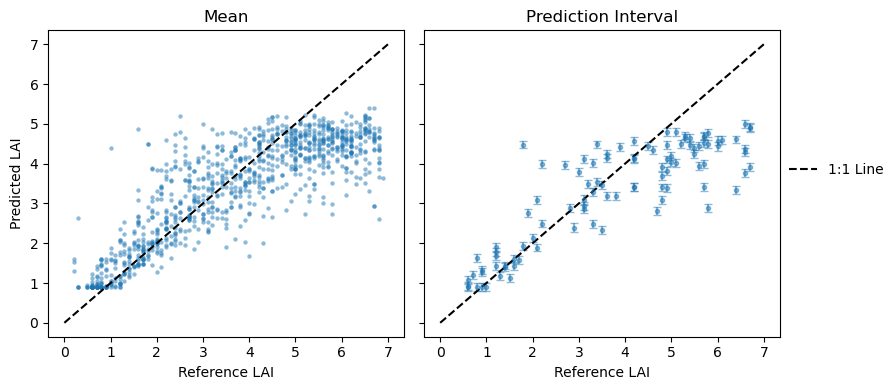

In [446]:
name = 'pnn_8_2_1_uni_E'
biome = 7

fig, axes = plt.subplots(1, 2, sharey=True, figsize=(8,4))

axes[0].scatter(np.divide(valbiomeDictLAI[biome]['y_test_1000'], scaling), np.divide(valbiomeDictLAI[biome][name]['mean_1000'], scaling), s=10, alpha=0.5, lw=0)
axes[0].plot([0, 7], [0, 7], 'k--', label='1:1 Line')

axes[0].set_xlabel("Reference LAI")
axes[0].set_ylabel("Predicted LAI")
axes[0].set_title('Mean')

axes[1].errorbar(np.divide(valbiomeDictLAI[biome]['y_test_100'], scaling), np.divide(valbiomeDictLAI[biome][name]['mean_100'], scaling), np.divide(valbiomeDictLAI[biome][name]['stddev_100'], scaling), fmt='o', ms=3, alpha=0.5, capsize=3)
axes[1].plot([0, 7], [0, 7], 'k--')

axes[1].set_xlabel("Reference LAI")
axes[1].set_title('Prediction Interval')

# plt.xlim([0, 7])
# plt.ylim([0, 7])

fig.tight_layout()

fig.legend(bbox_to_anchor=(1.12, 0.6), loc='centre left', frameon=0)
plt.show()

_**Figure 2.9.2** Predicted LAI with aleatoric and epistemic uncertainity from a probabilistic 8-2-1 neural network using a univariate distribution in comparison to the reference LAI. Left plot shows a comparison of the means with respect to 1000 valiadtion samples. Right plot shows mean predictions with error bars indicating the 68% confidence interval of each prediction with respect to 100 validation samples. A one-to-one is plotted to show relatively how well the predictions are. It can be observed that for LAI values greater than 4.5, the model tends to underpredict. This behaviour is expected._

### 2.10 Univariate Distribution: Aleatoric & Epistemic

#### 2.10.1 Defining the Model

In [447]:
# Define the model, negative-log likelihood as the loss function
# and compile the model with the Adam optimizer

name = 'pnn_8_2_1_uni'
biome = 7

valbiomeDictLAI[biome][name] = dict()

valbiomeDictLAI[biome][name]['model'] = tf.keras.Sequential([
    normalizer,
    tfpl.DenseVariational(units=8,
                          make_prior_fn=get_multivariate_prior,
                          make_posterior_fn=get_multivariate_posterior,
                          kl_weight=1/calbiomeDictLAI[biome]['X_train'].shape[0],
                          kl_use_exact=False,
                          activation='relu'),
    tfpl.DenseVariational(units=2,
                          make_prior_fn=get_multivariate_prior,
                          make_posterior_fn=get_multivariate_posterior,
                          kl_weight=1/calbiomeDictLAI[biome]['X_train'].shape[0],
                          kl_use_exact=False,
                          activation='relu'),
    tfpl.DenseVariational(units=2,
                          make_prior_fn=get_multivariate_prior,
                          make_posterior_fn=get_multivariate_posterior,
                          kl_weight=1/calbiomeDictLAI[biome]['X_train'].shape[0],
                          kl_use_exact=False),
    tfpl.DistributionLambda(
      lambda t: tfd.Normal(loc=t[..., :1],
                           scale=1e-3 + tf.math.softplus(0.01 * t[...,1:]))),
])

valbiomeDictLAI[biome][name]['model'].compile(loss=negloglik, optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), metrics=[tf.keras.metrics.RootMeanSquaredError()])
valbiomeDictLAI[biome][name]['model'].summary()

Model: "sequential_33"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 5)                3         
 n)                                                              
                                                                 
 dense_variational_87 (Dense  (None, 8)                1224      
 Variational)                                                    
                                                                 
 dense_variational_88 (Dense  (None, 2)                189       
 Variational)                                                    
                                                                 
 dense_variational_89 (Dense  (None, 2)                27        
 Variational)                                                    
                                                                 
 distribution_lambda_31 (Dis  ((None, 1),            

#### 2.10.2 Training the Model

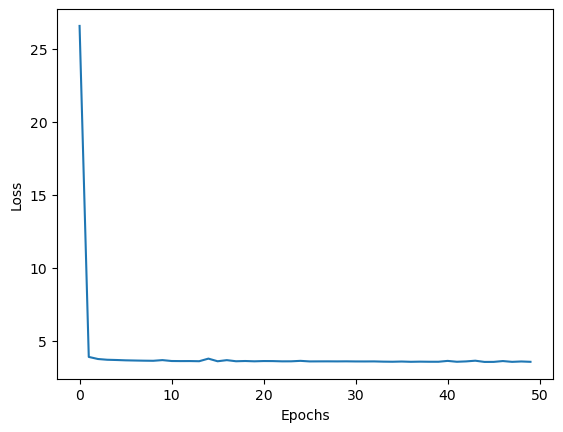

In [454]:
name = 'pnn_8_2_1_uni'
biome = 7

# Train the model for 50 epochs
# valbiomeDictLAI[biome][name]['history'] = valbiomeDictLAI[biome][name]['model'].fit(calbiomeDictLAI[biome]['X_train'].to_numpy(), calbiomeDictLAI[biome]['y_train'].to_numpy(), epochs=50, verbose=1)
plt.plot(valbiomeDictLAI[biome][name]['history'].history['loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

_**Figure 2.10.1** Loss convergence trained over 50 epochs for a probabilistic 8-2-1 neural network predicting aleatoric and epistemic uncertainty. Loss converges, indicating the model has been correctly trained._

#### 2.10.3 Making Predictions

In [449]:
name = 'pnn_8_2_1_uni'
biome = 7

valSize = [100, 1000]

for size in valSize:
    valbiomeDictLAI[biome][name]['y_model_' + str(size)] = valbiomeDictLAI[biome][name]['model'](valbiomeDictLAI[biome]['X_test_' + str(size)])

    # Prediction mean and stddev
    valbiomeDictLAI[biome][name]['mean_' + str(size)] = valbiomeDictLAI[biome][name]['y_model_' + str(size)].mean().numpy().flatten()
    valbiomeDictLAI[biome][name]['stddev_' + str(size)] = valbiomeDictLAI[biome][name]['y_model_' + str(size)].stddev().numpy().flatten()

    # Upper and lower bound of confidence interval
    # 1 stddev from the mean gives approx. the 68% confidence interval
    valbiomeDictLAI[biome][name]['lower_' + str(size)] = valbiomeDictLAI[biome][name]['mean_' + str(size)] - valbiomeDictLAI[biome][name]['stddev_' + str(size)]
    valbiomeDictLAI[biome][name]['upper_' + str(size)] = valbiomeDictLAI[biome][name]['mean_' + str(size)] + valbiomeDictLAI[biome][name]['stddev_' + str(size)]

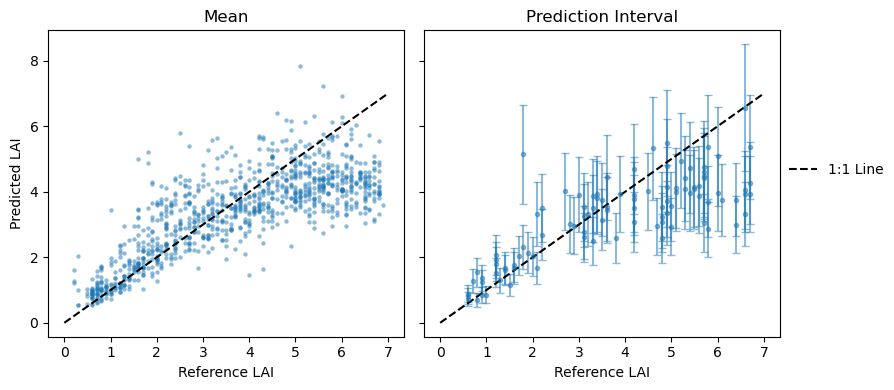

In [455]:
name = 'pnn_8_2_1_uni'
biome = 7

fig, axes = plt.subplots(1, 2, sharey=True, figsize=(8,4))

axes[0].scatter(np.divide(valbiomeDictLAI[biome]['y_test_1000'], scaling), np.divide(valbiomeDictLAI[biome][name]['mean_1000'], scaling), s=10, alpha=0.5, lw=0)
axes[0].plot([0, 7], [0, 7], 'k--', label='1:1 Line')

axes[0].set_xlabel("Reference LAI")
axes[0].set_ylabel("Predicted LAI")
axes[0].set_title('Mean')

axes[1].errorbar(np.divide(valbiomeDictLAI[biome]['y_test_100'], scaling), np.divide(valbiomeDictLAI[biome][name]['mean_100'], scaling), np.divide(valbiomeDictLAI[biome][name]['stddev_100'], scaling), fmt='o', ms=3, alpha=0.5, capsize=3)
axes[1].plot([0, 7], [0, 7], 'k--')

axes[1].set_xlabel("Reference LAI")
axes[1].set_title('Prediction Interval')

# plt.xlim([0, 7])
# plt.ylim([0, 7])

fig.tight_layout()

fig.legend(bbox_to_anchor=(1.12, 0.6), loc='centre left', frameon=0)
plt.show()

_**Figure 2.10.2** Predicted LAI with aleatoric and epistemic uncertainity from a probabilistic 8-2-1 neural network using a univariate distribution in comparison to the reference LAI. Left plot shows a comparison of the means with respect to 1000 valiadtion samples. Right plot shows mean predictions with error bars indicating the 68% confidence interval of each prediction with respect to 100 validation samples. A one-to-one is plotted to show relatively how well the predictions are. It can be observed that for LAI values greater than 4.5, the model tends to underpredict. This behaviour is expected._

### 2.11 Analysis

<a id=Figure-2.11.1></a>

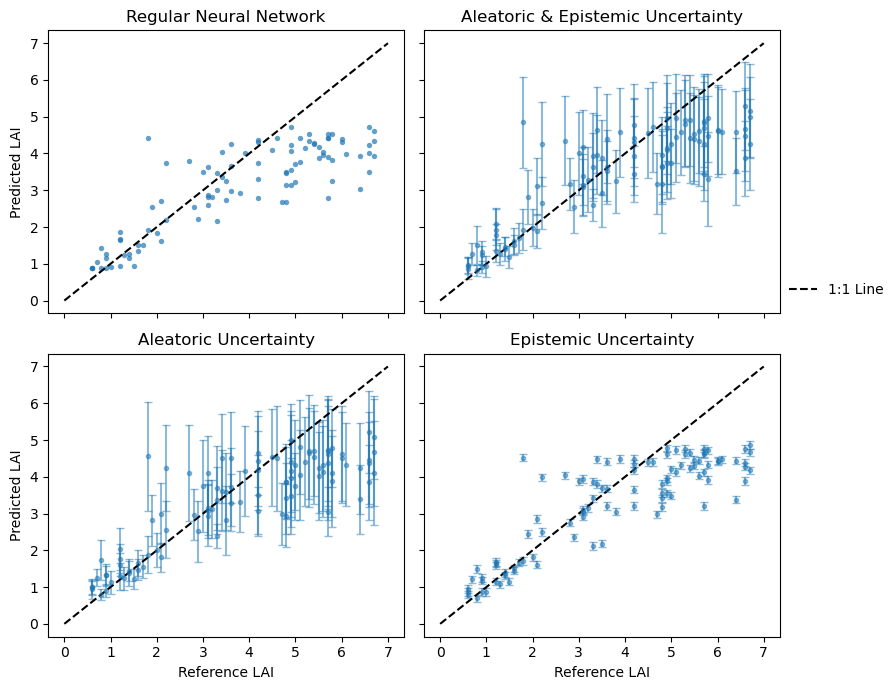

In [458]:
fig, axes = plt.subplots(2, 2, figsize=(8,7), sharey=True, sharex=True)

reference = (valbiomeDictLAI[biome]['y_test_100'].divide(scaling))

axes[0,0].scatter(reference, np.divide(valbiomeDictLAI[biome]['nn_80_25_1']['y_pred_100'], scaling), s=15, alpha=0.7, lw=0)
axes[0,0].set_ylabel("Predicted LAI")
axes[0,0].set_title("Regular Neural Network")
axes[0,0].plot([0, 7], [0, 7], 'k--', label='1:1 Line')

axes[0,1].errorbar(reference, np.divide(valbiomeDictLAI[biome]['pnn_80_25_1']['mean_100'], scaling), np.divide(valbiomeDictLAI[biome]['pnn_80_25_1']['stddev_100'], scaling), fmt='o', ms=3, alpha=0.5, capsize=3)
axes[0,1].set_title("Aleatoric & Epistemic Uncertainty")
axes[0,1].plot([0, 7], [0, 7], 'k--')

axes[1,0].errorbar(reference, np.divide(valbiomeDictLAI[biome]['pnn_80_25_1_A']['mean_100'], scaling), np.divide(valbiomeDictLAI[biome]['pnn_80_25_1_A']['stddev_100'], scaling), fmt='o', ms=3, alpha=0.5, capsize=3)
axes[1,0].set_xlabel("Reference LAI")
axes[1,0].set_ylabel("Predicted LAI")
axes[1,0].set_title("Aleatoric Uncertainty")
axes[1,0].plot([0, 7], [0, 7], 'k--')

axes[1,1].errorbar(reference, np.divide(valbiomeDictLAI[biome]['pnn_80_25_1_E']['mean_100'], scaling), np.divide(valbiomeDictLAI[biome]['pnn_80_25_1_E']['stddev_100'], scaling), fmt='o', ms=3, alpha=0.5, capsize=3)
axes[1,1].set_xlabel("Reference LAI")
axes[1,1].set_title("Epistemic Uncertainty")
axes[1,1].plot([0, 7], [0, 7], 'k--')

fig.legend(bbox_to_anchor=(1.12, 0.6), loc='centre left', frameon=0)
fig.tight_layout()
plt.show()

_**Figure 2.11.1** Predicted LAI from a 80-25-1 neural network using a multivariate distribution in comparison to the reference LAI. Top left plot shows a comparison of the predicted values using a regular neural network with respect to 1000 validation samples. Other three plots show mean predictions with error bars indicating the 68% confidence interval of each prediction with respect to 100 validation samples. A one-to-one is plotted to show relatively how well the predictions are. It can be observed that the mean predictions for all 4 scatter plots follow a similar trend, underpredicting after about LAI 4.5._

<a id='Figure-2.11.2'></a>

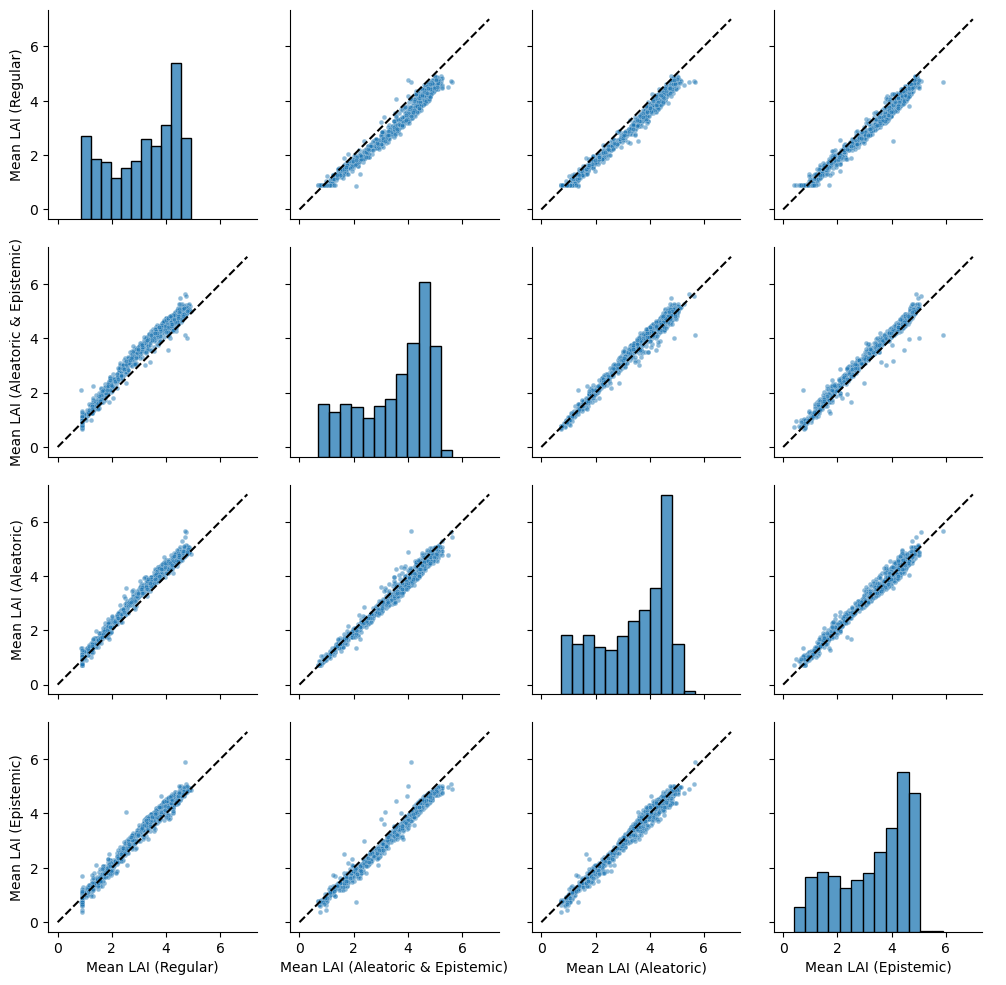

In [459]:
df = pd.DataFrame(data={
    'Mean LAI (Regular)': np.divide(valbiomeDictLAI[biome]['nn_80_25_1']['y_pred_1000'], scaling),
    'Mean LAI (Aleatoric & Epistemic)': np.divide(valbiomeDictLAI[biome]['pnn_80_25_1']['mean_1000'], scaling),
    'Mean LAI (Aleatoric)': np.divide(valbiomeDictLAI[biome]['pnn_80_25_1_A']['mean_1000'], scaling),
    'Mean LAI (Epistemic)': np.divide(valbiomeDictLAI[biome]['pnn_80_25_1_E']['mean_1000'], scaling)
})

def plot_unity(x, y, **kwargs):
    points = np.linspace(0, 7, 100)
    plt.plot(points, points, color='k', marker=None,
            linestyle='--', linewidth=1.5)

grid = sns.pairplot(df, kind='scatter', plot_kws={'alpha': 0.5, 's': 12, 'lw':0})
grid.map_offdiag(plot_unity, label='1:1 Line')
grid.add_legend()
plt.show()

_**Figure 2.11.2** Pairplot comparing the mean predictions of each model. In general, all models make similar predictions for each sample. It is observed that the epistemic uncertainty model predicts lower LAI values in comparison after about LAI 4.5._

<a id='Figure-2.11.3'></a>

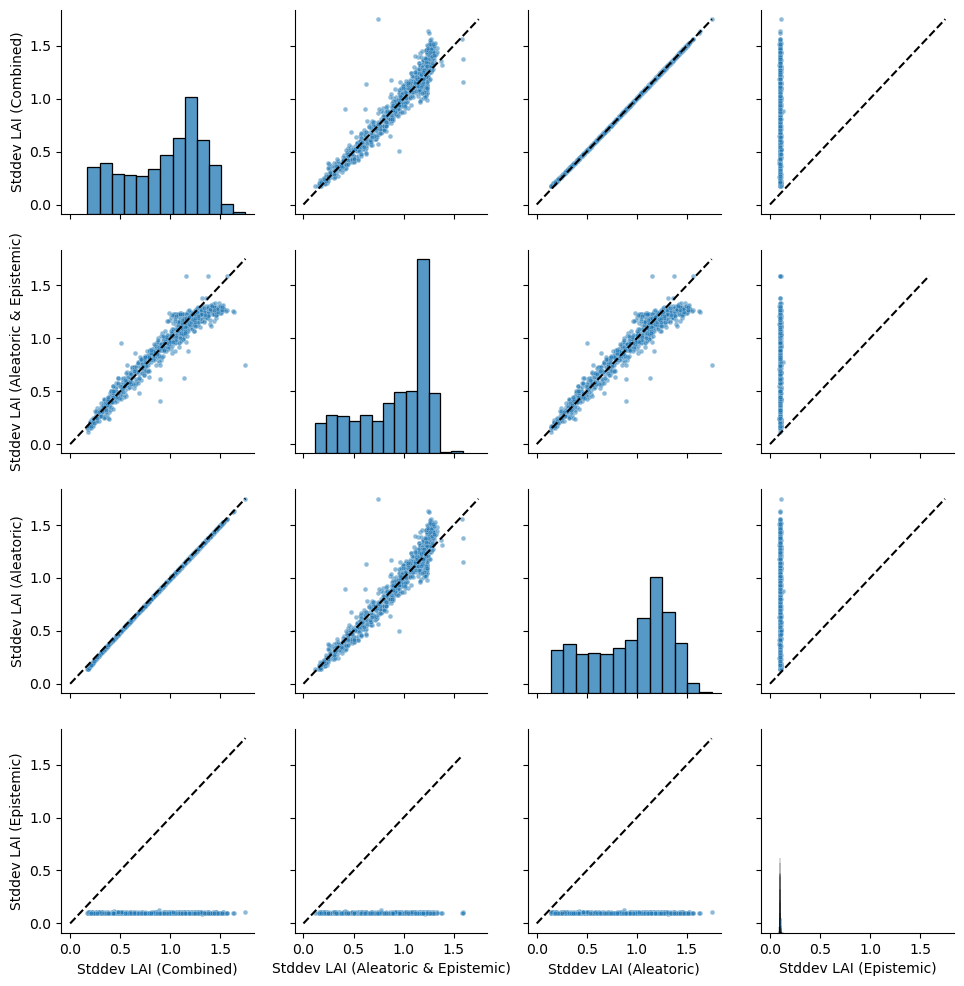

In [460]:
df = pd.DataFrame(data={
    'Stddev LAI (Combined)': np.divide(np.sqrt(np.add(np.square(valbiomeDictLAI[biome]['pnn_80_25_1_A']['stddev_1000']), np.square(valbiomeDictLAI[biome]['pnn_80_25_1_E']['stddev_1000']))), scaling),
    'Stddev LAI (Aleatoric & Epistemic)': np.divide(valbiomeDictLAI[biome]['pnn_80_25_1']['stddev_1000'], scaling),
    'Stddev LAI (Aleatoric)': np.divide(valbiomeDictLAI[biome]['pnn_80_25_1_A']['stddev_1000'], scaling),
    'Stddev LAI (Epistemic)': np.divide(valbiomeDictLAI[biome]['pnn_80_25_1_E']['stddev_1000'], scaling)
})

def plot_unity(x, y, **kwargs):
    mx = max(x.max(), y.max())
    points = np.linspace(0, mx, 100)
    plt.plot(points, points, color='k', marker=None,
            linestyle='--', linewidth=1.5)

grid = sns.pairplot(df, kind='scatter', plot_kws={'alpha': 0.5, 's': 12, 'lw':0})
grid.map_offdiag(plot_unity, label='1:1 Line')
# grid.add_legend()
plt.show()

_**Figure 2.11.3** Pairplot comparing the standard deviation of each model. The combined standard deviation is the Euclidean sum of the standard deviation of the epistemic and aleatoric model. It is observed that the epistemic uncertainty model has much lower standard deviation as expected. The standard deviation in the aleatoric model is very similar to the combined standard deviation. We would expect the aleatoric and epistemic uncertainty model to be the most similar to the combined model._

<a id='Figure-2.11.4'></a>

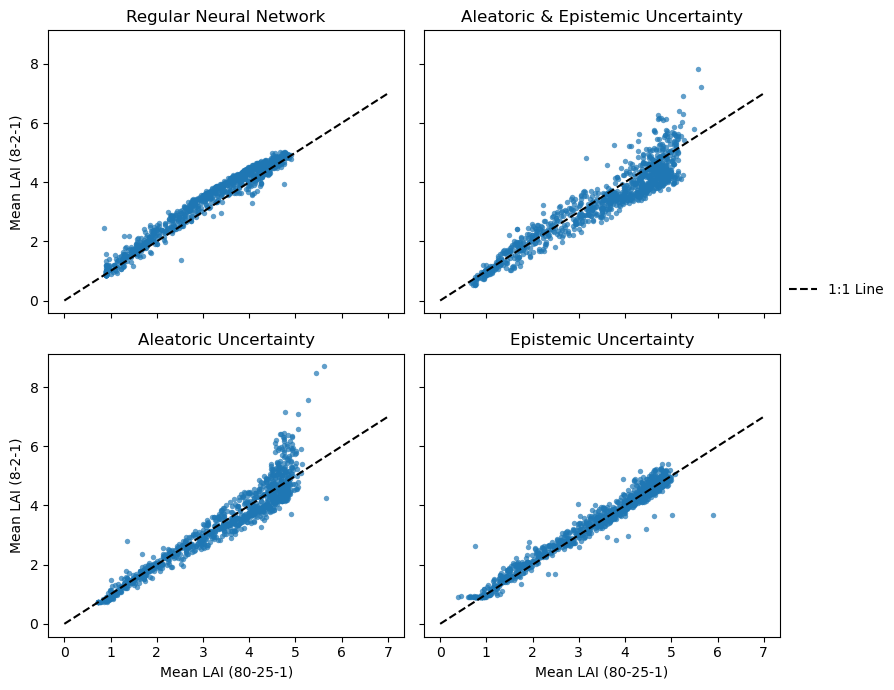

In [461]:
fig, axes = plt.subplots(2, 2, figsize=(8,7), sharey=True, sharex=True)

axes[0,0].scatter(x=np.divide(valbiomeDictLAI[biome]['nn_80_25_1']['y_pred_1000'], scaling), y=np.divide(valbiomeDictLAI[biome]['nn_8_2_1']['y_pred_1000'], scaling), s=15, alpha=0.7, lw=0)
axes[0,0].set_ylabel("Mean LAI (8-2-1)")
axes[0,0].set_title("Regular Neural Network")
axes[0,0].plot([0, 7], [0, 7], 'k--', label='1:1 Line')

axes[0,1].scatter(x=np.divide(valbiomeDictLAI[biome]['pnn_80_25_1']['mean_1000'], scaling), y=np.divide(valbiomeDictLAI[biome]['pnn_8_2_1_uni']['mean_1000'], scaling), s=15, alpha=0.7, lw=0)
axes[0,1].set_title("Aleatoric & Epistemic Uncertainty")
axes[0,1].plot([0, 7], [0, 7], 'k--')

axes[1,0].scatter(x=np.divide(valbiomeDictLAI[biome]['pnn_80_25_1_A']['mean_1000'], scaling), y=np.divide(valbiomeDictLAI[biome]['pnn_8_2_1_A']['mean_1000'], scaling), s=15, alpha=0.7, lw=0)
axes[1,0].set_xlabel("Mean LAI (80-25-1)")
axes[1,0].set_ylabel("Mean LAI (8-2-1)")
axes[1,0].set_title("Aleatoric Uncertainty")
axes[1,0].plot([0, 7], [0, 7], 'k--')

axes[1,1].scatter(x=np.divide(valbiomeDictLAI[biome]['pnn_80_25_1_E']['mean_1000'], scaling), y=np.divide(valbiomeDictLAI[biome]['pnn_8_2_1_uni_E']['mean_1000'], scaling), s=15, alpha=0.7, lw=0)
axes[1,1].set_xlabel("Mean LAI (80-25-1)")
axes[1,1].set_title("Epistemic Uncertainty")
axes[1,1].plot([0, 7], [0, 7], 'k--')

fig.legend(bbox_to_anchor=(1.12, 0.6), loc='centre left', frameon=0)
fig.tight_layout()
plt.show()

_**Figure 2.11.4** Comparing the mean predictions in the 8-2-1 and 80-25-1 neural networks both using a univariate distribution._

<a id='Figure-2.11.5'></a>

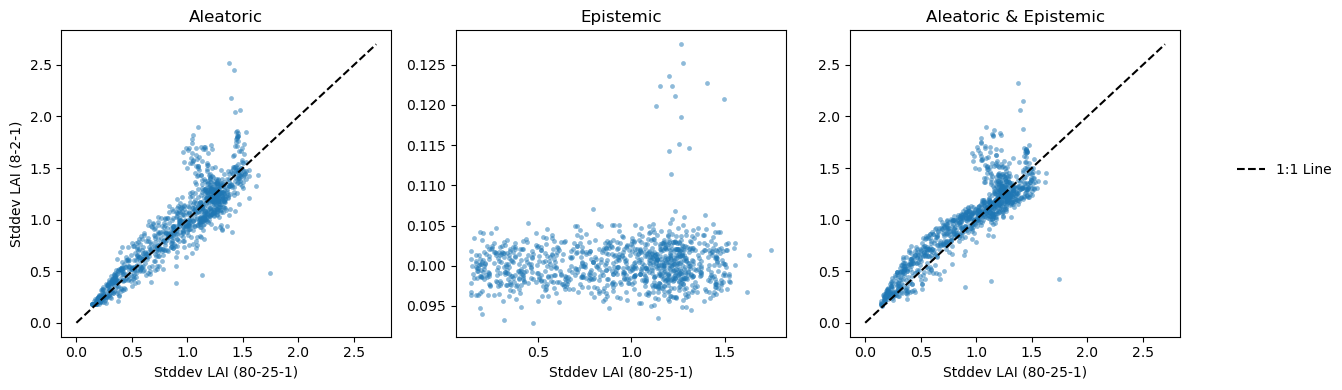

In [464]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4), sharey=False)

axes[0].scatter(x=np.divide(valbiomeDictLAI[biome]['pnn_80_25_1_A']['stddev_1000'], scaling), y=np.divide(valbiomeDictLAI[biome]['pnn_8_2_1_A']['stddev_1000'], scaling), alpha=0.5, s=12, lw=0)
axes[0].plot([0, 2.7], [0, 2.7], 'k--')
axes[0].set_xlabel("Stddev LAI (80-25-1)")
axes[0].set_ylabel("Stddev LAI (8-2-1)")
axes[0].set_title("Aleatoric")

axes[1].scatter(x=np.divide(valbiomeDictLAI[biome]['pnn_80_25_1_A']['stddev_1000'], scaling), y=np.divide(valbiomeDictLAI[biome]['pnn_8_2_1_uni_E']['stddev_1000'], scaling), alpha=0.5, s=12, lw=0)
# axes[1].plot([0, 2.7], [0, 2.7], 'k--')
axes[1].set_xlabel("Stddev LAI (80-25-1)")
axes[1].set_title("Epistemic")

axes[2].scatter(x=np.divide(valbiomeDictLAI[biome]['pnn_80_25_1_A']['stddev_1000'], scaling), y=np.divide(valbiomeDictLAI[biome]['pnn_8_2_1_uni']['stddev_1000'], scaling), alpha=0.5, s=12, lw=0)
axes[2].plot([0, 2.7], [0, 2.7], 'k--', label='1:1 Line')
axes[2].set_xlabel("Stddev LAI (80-25-1)")
axes[2].set_title("Aleatoric & Epistemic")

fig.legend(bbox_to_anchor=(1.12, 0.6), loc='centre left', frameon=0)
plt.tight_layout()
plt.show()

_**Figure 2.11.5** Comparing the standard deviation in the 8-2-1 and 80-25-1 neural networks both using a univariate distribution._

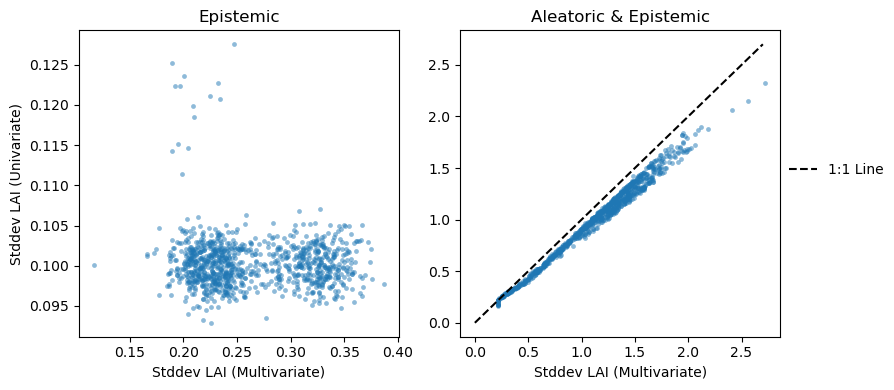

In [468]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4), sharey=False)

axes[0].scatter(np.divide(valbiomeDictLAI[biome]['pnn_8_2_1_multi_E']['stddev_1000'], scaling), np.divide(valbiomeDictLAI[biome]['pnn_8_2_1_uni_E']['stddev_1000'], scaling), alpha=0.5, s=12, lw=0)
# axes[1].plot([0, 2.7], [0, 2.7], 'k--')
axes[0].set_xlabel("Stddev LAI (Multivariate)")
axes[0].set_ylabel("Stddev LAI (Univariate)")
axes[0].set_title("Epistemic")

axes[1].scatter(np.divide(valbiomeDictLAI[biome]['pnn_8_2_1_multi']['stddev_1000'], scaling), np.divide(valbiomeDictLAI[biome]['pnn_8_2_1_uni']['stddev_1000'], scaling), alpha=0.5, s=12, lw=0)
axes[1].plot([0, 2.7], [0, 2.7], 'k--', label='1:1 Line')
axes[1].set_xlabel("Stddev LAI (Multivariate)")
axes[1].set_title("Aleatoric & Epistemic")

fig.legend(bbox_to_anchor=(1.12, 0.6), loc='centre left', frameon=0)
plt.tight_layout()
plt.show()

_**Figure 2.11.6** Comparing the standard deviation in the 8-2-1 network using a multivariate distribution and 8-2-1 network using a univariate distribution. The model using a univariate distribution has much lower epistemic uncertainty compared to the one using a multivariate distribution. It would be not reasonable to use a univariate distribution to resolve the issue of not having enough training data. It does not seem possible to accurately model epistemic uncertainity for large models._

## 3 Questions
1. Which predictor is better in general in terms of RMSE  and bias overall ?
2. What is the relative size of the actual prediction residual absolute residual to the prediction confidence interval?
3. Does the prediction confidence interval change as the sample size decreases?

In [373]:
valSize = [100, 1000]

for size in valSize:
    valbiomeDictLAI[biome]['rf']['rmse_' + str(size)] = metrics.mean_squared_error(valbiomeDictLAI[biome]['y_test_' + str(size)], valbiomeDictLAI[biome]['rf']['y_pred_' + str(size)], squared=False)
    valbiomeDictLAI[biome]['nn_80_25_1']['rmse_' + str(size)] = metrics.mean_squared_error(valbiomeDictLAI[biome]['y_test_' + str(size)], valbiomeDictLAI[biome]['nn_80_25_1']['y_pred_' + str(size)], squared=False)
    
    valbiomeDictLAI[biome]['rfqr']['residual_' + str(size)] = valbiomeDictLAI[biome]['y_test_' + str(size)] - valbiomeDictLAI[biome]['rfqr']['mean_' + str(size)]
    valbiomeDictLAI[biome]['pnn_80_25_1']['residual_' + str(size)] = valbiomeDictLAI[biome]['y_test_' + str(size)] - valbiomeDictLAI[biome]['pnn_80_25_1']['mean_' + str(size)]
    
    valbiomeDictLAI[biome]['rfqr']['abs_residual_' + str(size)] = np.abs(valbiomeDictLAI[biome]['rfqr']['residual_' + str(size)])
    valbiomeDictLAI[biome]['pnn_80_25_1']['abs_residual_' + str(size)] = np.abs(valbiomeDictLAI[biome]['pnn_80_25_1']['residual_' + str(size)])
    
    valbiomeDictLAI[biome]['rf']['bias_' + str(size)] = np.mean(valbiomeDictLAI[biome]['y_test_' + str(size)] - valbiomeDictLAI[biome]['rf']['y_pred_' + str(size)])
    valbiomeDictLAI[biome]['nn_80_25_1']['bias_' + str(size)] = np.mean(valbiomeDictLAI[biome]['y_test_' + str(size)] - valbiomeDictLAI[biome]['nn_80_25_1']['y_pred_' + str(size)])

### Question 1
Which predictor is better in general in terms of RMSE and bias overall?

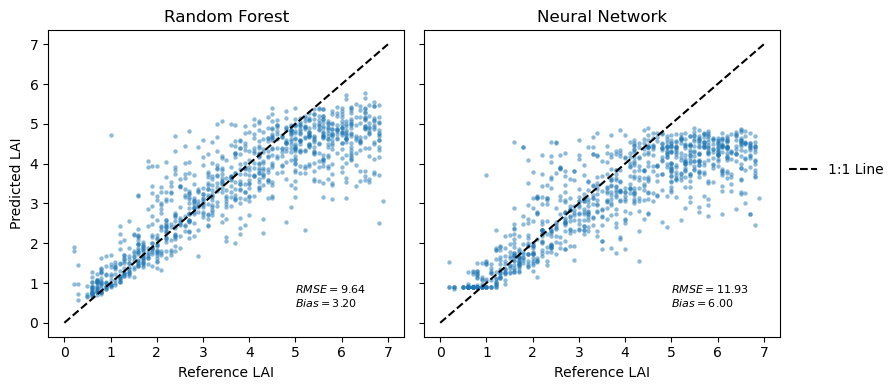

In [374]:
# Scatter plots (with 1000 validation samples only) of each estimated versus predicted together
fig, axs = plt.subplots(1,2, figsize=(8,4), sharey=True)
axs[0].scatter(x=np.divide(valbiomeDictLAI[biome]['y_test_1000'], scaling), y=np.divide(valbiomeDictLAI[biome]['rf']['y_pred_1000'], scaling), s=10, lw=0, alpha=0.5)
axs[1].scatter(x=np.divide(valbiomeDictLAI[biome]['y_test_1000'], scaling), y=np.divide(valbiomeDictLAI[biome]['nn_80_25_1']['y_pred_1000'], scaling), s=10, lw=0, alpha=0.5)

axs[0].set_title("Random Forest")
axs[0].set_xlabel("Reference LAI")
axs[0].set_ylabel("Predicted LAI")

axs[1].set_title("Neural Network")
axs[1].set_xlabel("Reference LAI")

axs[0].plot([0, 7], [0, 7], 'k--', label='1:1 Line')
# axs[0].xlim([-10, 80])
# axs[0].ylim([-10, 80])

axs[1].plot([0, 7], [0, 7], 'k--')
# axs[1].xlim([-10, 80])
# axs[1].ylim([-10, 80])

txt = '\n'.join((
    r'$RMSE=%.2f$' % (valbiomeDictLAI[biome]['rf']['rmse_1000'], ),
    r'$Bias=%.2f$' % (valbiomeDictLAI[biome]['rf']['bias_1000'], )))
axs[0].text(5, 1, txt, fontsize=8,verticalalignment='top', color='black')

txt = '\n'.join((
    r'$RMSE=%.2f$' % (valbiomeDictLAI[biome]['nn_80_25_1']['rmse_1000'], ),
    r'$Bias=%.2f$' % (valbiomeDictLAI[biome]['nn_80_25_1']['bias_1000'], )))
axs[1].text(5, 1, txt, fontsize=8,verticalalignment='top', color='black')

fig.tight_layout()
fig.legend(bbox_to_anchor=(1.12, 0.6), loc='centre left', frameon=0)

_**Figure 3.1** Comparing the Scikit-learn random forest regressor and the regular Tensorflow neural network. The RMSE and Bias of each predictor is marked. The random forest seems to make better predictions after LAI 5. The random forest regressor also seems to do better in terms of RMSE and bias._

### Question 2
What is the relative size of the actual prediction residual absolute residual to the prediction confidence interval?

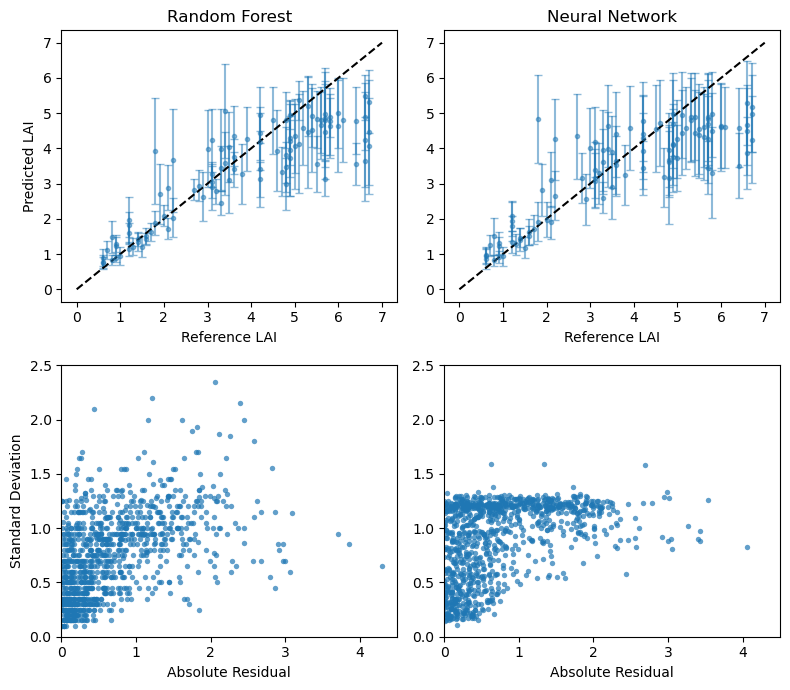

In [375]:
reference = (valbiomeDictLAI[biome]['y_test_100'].divide(scaling))

fig, axes = plt.subplots(2, 2, figsize=(8,7))

axes[0,0].errorbar(reference, np.divide(valbiomeDictLAI[biome]['rfqr']['mean_100'], scaling), np.divide(valbiomeDictLAI[biome]['rfqr']['stddev_100'], scaling), fmt='o', ms=3, alpha=0.5, capsize=3)
axes[0,0].set_ylabel("Predicted LAI")
axes[0,0].set_xlabel("Reference LAI")
axes[0,0].set_title("Random Forest")
axes[0,0].plot([0, 7], [0, 7], 'k--')

axes[0,1].errorbar(reference, np.divide(valbiomeDictLAI[biome]['pnn_80_25_1']['mean_100'], scaling), np.divide(valbiomeDictLAI[biome]['pnn_80_25_1']['stddev_100'], scaling), fmt='o', ms=3, alpha=0.5, capsize=3)
axes[0,1].set_title("Neural Network")
axes[0,1].set_xlabel("Reference LAI")
axes[0,1].plot([0, 7], [0, 7], 'k--', label='1:1 Line')

axes[1,0].scatter(np.divide(valbiomeDictLAI[biome]['rfqr']['abs_residual_1000'], scaling), np.divide(valbiomeDictLAI[biome]['rfqr']['stddev_1000'], scaling), s=15, alpha=0.7, lw=0)
axes[1,0].set_xlabel("Absolute Residual")
axes[1,0].set_ylabel("Standard Deviation")
axes[1,0].set_xlim(0, 4.5)
axes[1,0].set_ylim(0, 2.5)

axes[1,1].scatter(np.divide(valbiomeDictLAI[biome]['pnn_80_25_1']['abs_residual_1000'], scaling), np.divide(valbiomeDictLAI[biome]['pnn_80_25_1']['stddev_1000'], scaling), s=15, alpha=0.7, lw=0)
axes[1,1].set_xlabel("Absolute Residual")
axes[1,1].set_xlim(0, 4.5)
axes[1,1].set_ylim(0, 2.5)


fig.tight_layout()

_**Figure 3.2** Comparing the confidence interval of the Scikit-garden random forest regressor with standard deviation and the TFP neural network. The top two plots show the mean prediction with error bars indicating the 68% confidence interval. The bottom two show standard deviation against the absolute residual of the predictions._

### Question 3
Does the prediction confidence interval change as the sample size decreases?  

In [376]:
# List of regressors
regressors = ['red','NIR','cosSZA','cosVZA','cosSA']
# Response
response = 'LAI'

# Sample 50% of the calibration data
for i in biomes:
    dfcal = calbiomeDictLAI[i]['DF'].sample(frac=0.5)
    calbiomeDictLAI[i]['X_train_50'] = dfcal[regressors]
    calbiomeDictLAI[i]['y_train_50'] = dfcal[response]

#### Training a random forest regressor with 50% of the calibration samples
We use the same model as defined in *[section 1.3.1](#1.3.1-Defining-the-Model)* but train it with only 50% of the calibration samples.

In [274]:
name = 'rfr_s50'
biome = 7

valbiomeDictLAI[biome][name] = dict()

# Defining the model
valbiomeDictLAI[biome][name]['model'] = rfrgarden(n_estimators=100,min_samples_leaf=10,max_features=5,bootstrap=True,random_state=0,verbose=0,n_jobs=-1,max_leaf_nodes=10000)

# Training the model
valbiomeDictLAI[biome][name]['model'] = valbiomeDictLAI[biome][name]['model'].fit(calbiomeDictLAI[biome]['X_train_50'], calbiomeDictLAI[biome]['y_train_50'])

valSize = [100, 1000]

# Making predictions for 100 and 1000 validation samples
for size in valSize:
    # Prediction mean and stddev
    valbiomeDictLAI[biome][name]['mean_' + str(size)], valbiomeDictLAI[biome][name]['stddev_' + str(size)] = valbiomeDictLAI[biome][name]['model'].predict(valbiomeDictLAI[biome]['X_test_' + str(size)], return_std=True)

    # Upper and lower bound of confidence interval
    # 1 stddev from the mean gives approx. the 68% confidence interval
    valbiomeDictLAI[biome][name]['lower_' + str(size)] = valbiomeDictLAI[biome][name]['mean_' + str(size)] - valbiomeDictLAI[biome][name]['stddev_' + str(size)]
    valbiomeDictLAI[biome][name]['upper_' + str(size)] = valbiomeDictLAI[biome][name]['mean_' + str(size)] + valbiomeDictLAI[biome][name]['stddev_' + str(size)]

#### Training a neural network with 50% of the calibration samples
We use the same model as defined in *[section 2.4.1](#2.4.1-Defining-the-Model)* but train it with only 50% of the calibration samples.

In [300]:
name = 'pnn_80_25_1_s50'
biome = 7

valbiomeDictLAI[biome][name] = dict()

# Defining the model
valbiomeDictLAI[biome][name]['model'] = tf.keras.Sequential([
    normalizer,
    tfpl.DenseVariational(units=8,
                          make_prior_fn=get_prior,
                          make_posterior_fn=get_posterior,
                          kl_weight=1/calbiomeDictLAI[biome]['X_train_50'].shape[0],
                          kl_use_exact=False,
                          activation='relu'),
    tfpl.DenseVariational(units=2,
                          make_prior_fn=get_prior,
                          make_posterior_fn=get_posterior,
                          kl_weight=1/calbiomeDictLAI[biome]['X_train_50'].shape[0],
                          kl_use_exact=False,
                          activation='relu'),
    tfpl.DenseVariational(units=2,
                          make_prior_fn=get_prior,
                          make_posterior_fn=get_posterior,
                          kl_weight=1/calbiomeDictLAI[biome]['X_train_50'].shape[0],
                          kl_use_exact=False),
    tfpl.DistributionLambda(
      lambda t: tfd.Normal(loc=t[..., :1],
                           scale=1e-3 + tf.math.softplus(0.01 * t[...,1:]))),
])

# Compiling the model
valbiomeDictLAI[biome][name]['model'].compile(loss=negloglik, optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), metrics=[tf.keras.metrics.RootMeanSquaredError()])

# Training the model
valbiomeDictLAI[biome][name]['history'] = valbiomeDictLAI[biome][name]['model'].fit(calbiomeDictLAI[biome]['X_train_50'].to_numpy(), calbiomeDictLAI[biome]['y_train_50'].to_numpy(), epochs=50, verbose=1)

valSize = [100, 1000]

# Making predictions for 100 and 1000 validation samples
for size in valSize:
    valbiomeDictLAI[biome][name]['y_model_' + str(size)] = valbiomeDictLAI[biome][name]['model'](valbiomeDictLAI[biome]['X_test_' + str(size)])

    # Prediction mean and stddev
    valbiomeDictLAI[biome][name]['mean_' + str(size)] = valbiomeDictLAI[biome][name]['y_model_' + str(size)].mean().numpy().flatten()
    valbiomeDictLAI[biome][name]['stddev_' + str(size)] = valbiomeDictLAI[biome][name]['y_model_' + str(size)].stddev().numpy().flatten()

    # Upper and lower bound of confidence interval
    # 1 stddev from the mean gives approx. the 68% confidence interval
    valbiomeDictLAI[biome][name]['lower_' + str(size)] = valbiomeDictLAI[biome][name]['mean_' + str(size)] - valbiomeDictLAI[biome][name]['stddev_' + str(size)]
    valbiomeDictLAI[biome][name]['upper_' + str(size)] = valbiomeDictLAI[biome][name]['mean_' + str(size)] + valbiomeDictLAI[biome][name]['stddev_' + str(size)]

Epoch 1/50
5886/5886 [==============================] - 23s 3ms/step - loss: 48.8398 - root_mean_squared_error: 17.5733
Epoch 2/50
5886/5886 [==============================] - 19s 3ms/step - loss: 4.0405 - root_mean_squared_error: 18.8634
Epoch 3/50
5886/5886 [==============================] - 19s 3ms/step - loss: 3.9696 - root_mean_squared_error: 18.6218
Epoch 4/50
5886/5886 [==============================] - 20s 3ms/step - loss: 3.8841 - root_mean_squared_error: 17.4530
Epoch 5/50
5886/5886 [==============================] - 20s 3ms/step - loss: 3.9180 - root_mean_squared_error: 19.3094
Epoch 6/50
5886/5886 [==============================] - 19s 3ms/step - loss: 3.7747 - root_mean_squared_error: 15.8230
Epoch 7/50
5886/5886 [==============================] - 19s 3ms/step - loss: 3.7342 - root_mean_squared_error: 15.5758
Epoch 8/50
5886/5886 [==============================] - 18s 3ms/step - loss: 3.7164 - root_mean_squared_error: 15.5848
Epoch 9/50
5886/5886 [=========================

In [332]:
name = 'pnn_8_2_1_s50'
biome = 7

valbiomeDictLAI[biome][name] = dict()

# Defining the model
valbiomeDictLAI[biome][name]['model'] = tf.keras.Sequential([
    normalizer,
    tfpl.DenseVariational(units=8,
                          make_prior_fn=get_prior,
                          make_posterior_fn=get_posterior,
                          kl_weight=1/calbiomeDictLAI[biome]['X_train_50'].shape[0],
                          kl_use_exact=False,
                          activation='relu'),
    tfpl.DenseVariational(units=2,
                          make_prior_fn=get_prior,
                          make_posterior_fn=get_posterior,
                          kl_weight=1/calbiomeDictLAI[biome]['X_train_50'].shape[0],
                          kl_use_exact=False,
                          activation='relu'),
    tfpl.DenseVariational(units=2,
                          make_prior_fn=get_prior,
                          make_posterior_fn=get_posterior,
                          kl_weight=1/calbiomeDictLAI[biome]['X_train_50'].shape[0],
                          kl_use_exact=False),
    tfpl.DistributionLambda(
      lambda t: tfd.Normal(loc=t[..., :1],
                           scale=1e-3 + tf.math.softplus(0.01 * t[...,1:]))),
])

# Compiling the model
valbiomeDictLAI[biome][name]['model'].compile(loss=negloglik, optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), metrics=[tf.keras.metrics.RootMeanSquaredError()])

# Training the model
valbiomeDictLAI[biome][name]['history'] = valbiomeDictLAI[biome][name]['model'].fit(calbiomeDictLAI[biome]['X_train_50'].to_numpy(), calbiomeDictLAI[biome]['y_train_50'].to_numpy(), epochs=50, verbose=1)

valSize = [100, 1000]

# Making predictions for 100 and 1000 validation samples
for size in valSize:
    valbiomeDictLAI[biome][name]['y_model_' + str(size)] = valbiomeDictLAI[biome][name]['model'](valbiomeDictLAI[biome]['X_test_' + str(size)])

    # Prediction mean and stddev
    valbiomeDictLAI[biome][name]['mean_' + str(size)] = valbiomeDictLAI[biome][name]['y_model_' + str(size)].mean().numpy().flatten()
    valbiomeDictLAI[biome][name]['stddev_' + str(size)] = valbiomeDictLAI[biome][name]['y_model_' + str(size)].stddev().numpy().flatten()

    # Upper and lower bound of confidence interval
    # 1 stddev from the mean gives approx. the 68% confidence interval
    valbiomeDictLAI[biome][name]['lower_' + str(size)] = valbiomeDictLAI[biome][name]['mean_' + str(size)] - valbiomeDictLAI[biome][name]['stddev_' + str(size)]
    valbiomeDictLAI[biome][name]['upper_' + str(size)] = valbiomeDictLAI[biome][name]['mean_' + str(size)] + valbiomeDictLAI[biome][name]['stddev_' + str(size)]

Epoch 1/50
5886/5886 [==============================] - 31s 4ms/step - loss: 44.6857 - root_mean_squared_error: 17.6566
Epoch 2/50
5886/5886 [==============================] - 24s 4ms/step - loss: 4.0339 - root_mean_squared_error: 18.9658
Epoch 3/50
5886/5886 [==============================] - 24s 4ms/step - loss: 3.9739 - root_mean_squared_error: 18.7972
Epoch 4/50
5886/5886 [==============================] - 25s 4ms/step - loss: 3.8619 - root_mean_squared_error: 17.1788
Epoch 5/50
5886/5886 [==============================] - 25s 4ms/step - loss: 3.8145 - root_mean_squared_error: 16.7706
Epoch 6/50
5886/5886 [==============================] - 24s 4ms/step - loss: 3.7566 - root_mean_squared_error: 16.0049
Epoch 7/50
5886/5886 [==============================] - 27s 5ms/step - loss: 3.7754 - root_mean_squared_error: 16.4723
Epoch 8/50
5886/5886 [==============================] - 26s 4ms/step - loss: 3.7096 - root_mean_squared_error: 15.4814
Epoch 9/50
5886/5886 [=========================

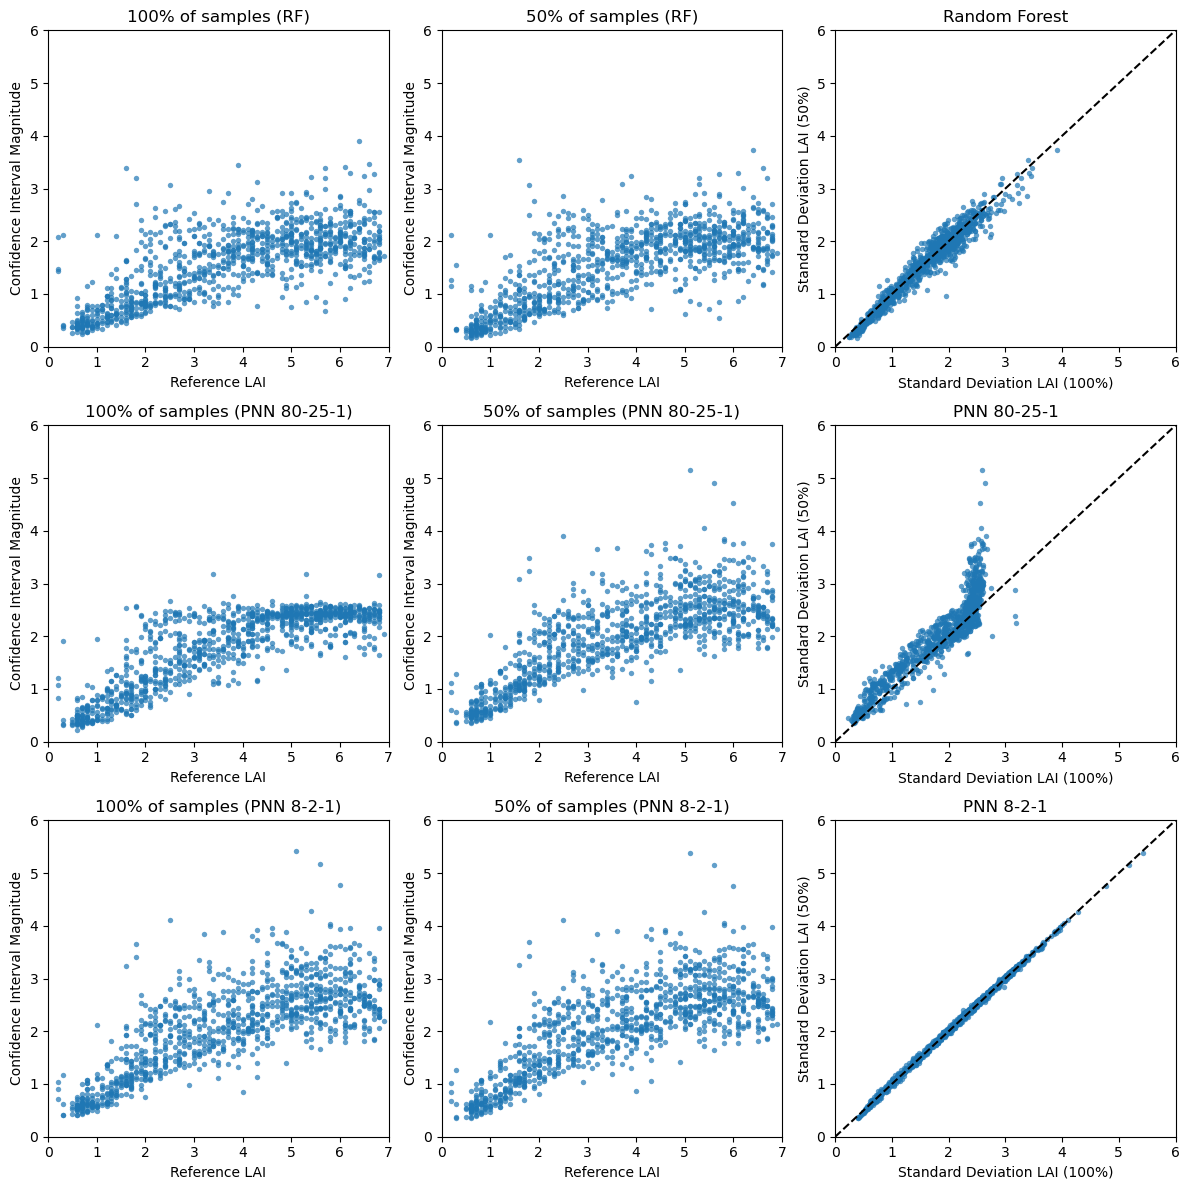

In [378]:
fig, axes = plt.subplots(3, 3, figsize=(12,12))

# Random Forest

axes[0,0].scatter(np.divide(valbiomeDictLAI[biome]['y_test_1000'], scaling), np.divide(2 * valbiomeDictLAI[biome]['rfstddev']['stddev_1000'], scaling), s=15, alpha=0.7, lw=0)
axes[0,0].set_xlabel("Reference LAI")
axes[0,0].set_ylabel("Confidence Interval Magnitude")
axes[0,0].set_title("100% of samples (RF)")
axes[0,0].set_xlim(0,7)
axes[0,0].set_ylim(0,6)
# axes[1,0].plot([0, 7], [0, 7], 'k--')

axes[0,1].scatter(np.divide(valbiomeDictLAI[biome]['y_test_1000'], scaling), np.divide(2 * valbiomeDictLAI[biome]['rfr_s50']['stddev_1000'], scaling), s=15, alpha=0.7, lw=0)
axes[0,1].set_xlabel("Reference LAI")
axes[0,1].set_ylabel("Confidence Interval Magnitude")
axes[0,1].set_title("50% of samples (RF)")
axes[0,1].set_xlim(0,7)
axes[0,1].set_ylim(0,6)
# axes[1,1].plot([0, 7], [0, 7], 'k--')

axes[0,2].scatter(np.divide(2 * valbiomeDictLAI[biome]['rfstddev']['stddev_1000'], scaling), np.divide(2 * valbiomeDictLAI[biome]['rfr_s50']['stddev_1000'], scaling), s=15, alpha=0.7, lw=0)
axes[0,2].set_ylabel("Standard Deviation LAI (50%)")
axes[0,2].set_xlabel("Standard Deviation LAI (100%)")
axes[0,2].set_title("Random Forest")
axes[0,2].set_xlim(0,6)
axes[0,2].set_ylim(0,6)
axes[0,2].plot([0, 6], [0, 6], 'k--')

######################################################################################################################################################################################################

# PNN_80_25_1

axes[1,0].scatter(np.divide(valbiomeDictLAI[biome]['y_test_1000'], scaling), np.divide(2 * valbiomeDictLAI[biome]['pnn_80_25_1']['stddev_1000'], scaling), s=15, alpha=0.7, lw=0)
axes[1,0].set_xlabel("Reference LAI")
axes[1,0].set_ylabel("Confidence Interval Magnitude")
axes[1,0].set_title("100% of samples (PNN 80-25-1)")
axes[1,0].set_xlim(0,7)
axes[1,0].set_ylim(0,6)

axes[1,1].scatter(np.divide(valbiomeDictLAI[biome]['y_test_1000'], scaling), np.divide(2 * valbiomeDictLAI[biome]['pnn_80_25_1_s50']['stddev_1000'], scaling), s=15, alpha=0.7, lw=0)
axes[1,1].set_xlabel("Reference LAI")
axes[1,1].set_ylabel("Confidence Interval Magnitude")
axes[1,1].set_title("50% of samples (PNN 80-25-1)")
axes[1,1].set_xlim(0,7)
axes[1,1].set_ylim(0,6)

axes[1,2].scatter(np.divide(2 * valbiomeDictLAI[biome]['pnn_80_25_1']['stddev_1000'], scaling), np.divide(2 * valbiomeDictLAI[biome]['pnn_80_25_1_s50']['stddev_1000'], scaling), s=15, alpha=0.7, lw=0)
axes[1,2].set_ylabel("Standard Deviation LAI (50%)")
axes[1,2].set_xlabel("Standard Deviation LAI (100%)")
axes[1,2].set_title("PNN 80-25-1")
axes[1,2].set_xlim(0,6)
axes[1,2].set_ylim(0,6)
axes[1,2].plot([0, 6], [0, 6], 'k--', label='1:1 Line')

######################################################################################################################################################################################################

# PNN_8_2_1

axes[2,0].scatter(np.divide(valbiomeDictLAI[biome]['y_test_1000'], scaling), np.divide(2 * valbiomeDictLAI[biome]['pnn_8_2_1']['stddev_1000'], scaling), s=15, alpha=0.7, lw=0)
axes[2,0].set_xlabel("Reference LAI")
axes[2,0].set_ylabel("Confidence Interval Magnitude")
axes[2,0].set_title("100% of samples (PNN 8-2-1)")
axes[2,0].set_xlim(0,7)
axes[2,0].set_ylim(0,6)

axes[2,1].scatter(np.divide(valbiomeDictLAI[biome]['y_test_1000'], scaling), np.divide(2 * valbiomeDictLAI[biome]['pnn_8_2_1_s50']['stddev_1000'], scaling), s=15, alpha=0.7, lw=0)
axes[2,1].set_xlabel("Reference LAI")
axes[2,1].set_ylabel("Confidence Interval Magnitude")
axes[2,1].set_title("50% of samples (PNN 8-2-1)")
axes[2,1].set_xlim(0,7)
axes[2,1].set_ylim(0,6)

axes[2,2].scatter(np.divide(2 * valbiomeDictLAI[biome]['pnn_8_2_1']['stddev_1000'], scaling), np.divide(2 * valbiomeDictLAI[biome]['pnn_8_2_1_s50']['stddev_1000'], scaling), s=15, alpha=0.7, lw=0)
axes[2,2].set_ylabel("Standard Deviation LAI (50%)")
axes[2,2].set_xlabel("Standard Deviation LAI (100%)")
axes[2,2].set_title("PNN 8-2-1")
axes[2,2].set_xlim(0,6)
axes[2,2].set_ylim(0,6)
axes[2,2].plot([0, 6], [0, 6], 'k--', label='1:1 Line')

fig.tight_layout()

_**Figure 3.3** Comparison of standard deviation and confidence interval between using 100% and 50% of the calibration sample._